In [84]:
import numpy                 as np
import matplotlib.pyplot     as plt
import pandas                as pd
import yfinance              as yf
import seaborn               as sns

from   scipy.stats import percentileofscore


## 1. Rolling Means and trend following strategies

In [85]:
tickers = ['^GSPC', 'AMD', 'MSFT', 'INTC']

# Creating a dictionary to store data for each ticker
stock_data = {}

# Loading historical data for each ticker
for ticker in tickers:
    stock_data[ticker] = yf.Ticker(ticker).history(start='2008-01-05', auto_adjust=True)

In [86]:
Min_A, Max_A = 5,80
Min_B, Max_B = 5,80
Window_A = np.arange(Min_A,Max_A,5)
Window_B = np.arange(Min_B,Max_B,5)

In [87]:
def trend_following(ticker,Window_A, Window_B,stock_data=stock_data):

    Performance = np.zeros((Window_A.shape[0],Window_B.shape[0]))
    strategies  = []
    for i in range(Window_A.shape[0]):
        strategies.append([])

        for j in range(Window_B.shape[0]):

            strategies[i].append([])

            A=Window_A[i]
            B=Window_B[j]
           
            Stock = stock_data[ticker].copy()

            Rolling_mean_A = stock_data[ticker]['Close'].rolling(A).mean()
            Rolling_mean_B = stock_data[ticker]['Close'].rolling(B).mean()
            
            Stock['Rolling_mean_A'] = Rolling_mean_A
            Stock['Rolling_mean_B'] = Rolling_mean_B
            
            Stock.dropna(inplace=True)
            Stock['Trade_sign'] = np.where(Stock['Rolling_mean_A'] > Stock['Rolling_mean_B'], 1, 0)
            Stock['Trade_sign'] = Stock['Trade_sign'].shift(1)
            #Stock['Strategy_Return'] = (Stock['Close'] - Stock['Close'].shift(1)) / Stock['Close'].shift(1)
            Stock['Strategy_Return']=Stock['Close'].pct_change()
            Stock.dropna(inplace=True)
            Stock['Strategy_Return'] *= Stock['Trade_sign']
            Stock.dropna(inplace=True)
            strategies[i][j]=Stock['Strategy_Return'].values
            Performance[i,j]=Stock['Strategy_Return'].mean()*252

    return Performance,strategies

In [88]:
Performances ={}
strategies={}
for ticker in tickers:
    
    Performance,strategy = trend_following(ticker,Window_A, Window_B)
    Performances[ticker]=Performance
    strategies[ticker]=strategy

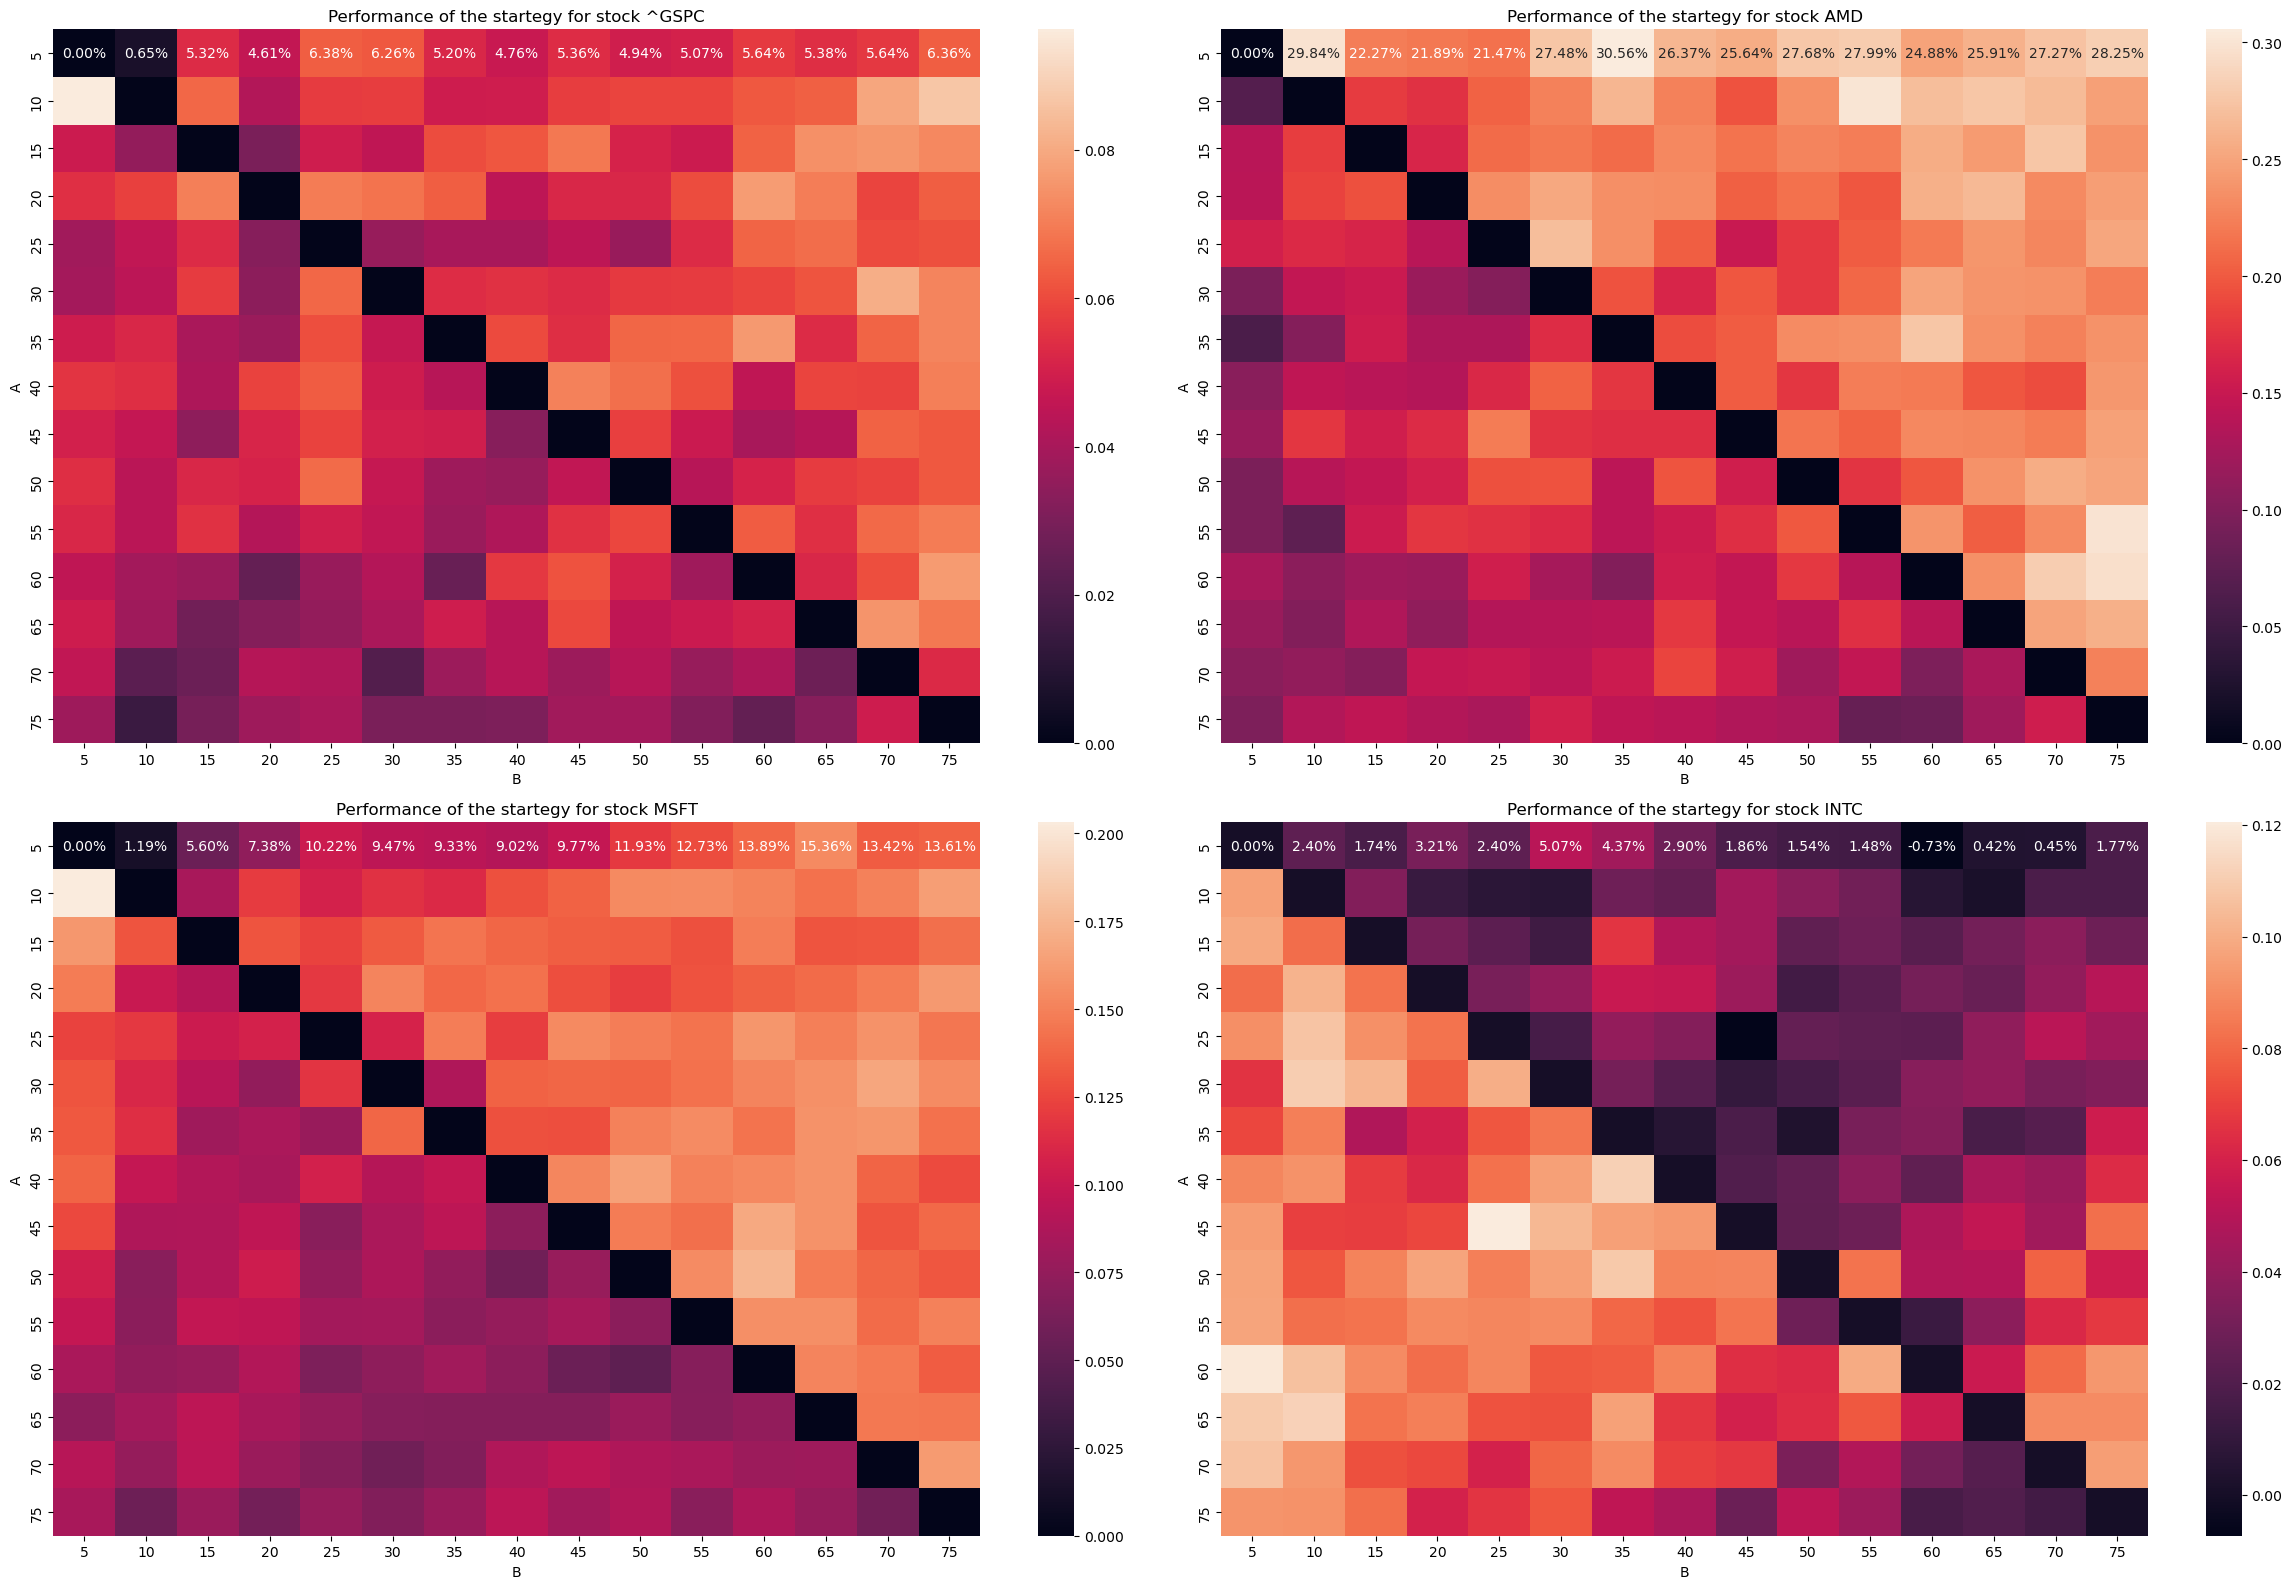

In [89]:
fig,ax=plt.subplots(2,2,figsize=(24,16))

for i in range(2):
    for j in range(2):
        
        ticker=tickers[i*2+j]
        sns.heatmap(Performances[ticker],ax=ax[i,j],annot=True,fmt='.2%',yticklabels=Window_A, xticklabels=Window_B)
        ax[i,j].set_xlabel('B')
        ax[i,j].set_ylabel('A')
        ax[i,j].set_title('Performance of the startegy for stock '+str(ticker))


plt.tight_layout()
plt.show()

We choose as a performance metric the mean of the strategy's return (another performance metric could have been the sharp ratio).\
We notice that for some stocks when A< B we have a better retrun, i.e buying the stock when the mean of its price on the A window is higher than in the B windows and holding it otherwise results in better return then doing the opposite.\
The performance of the strategy heavily depends on the stock: 
- For AMD  have quite high returns 
- For INTC we have quite low returns 
- For MSFT we have average returns

Below we plot the cumulative performance of this strategy on AMD (high return) and INTC (low return):

In [90]:
stock=stock_data.copy()
stock['AMD']['Return']=stock['AMD']['Close'].pct_change()
stock['INTC']['Return']=stock['INTC']['Close'].pct_change()

stock['AMD']['Cumulatuive return']=(1+stock['AMD']['Return']).cumprod()-1
stock['INTC']['Cumulatuive return']=(1+stock['INTC']['Return']).cumprod()-1

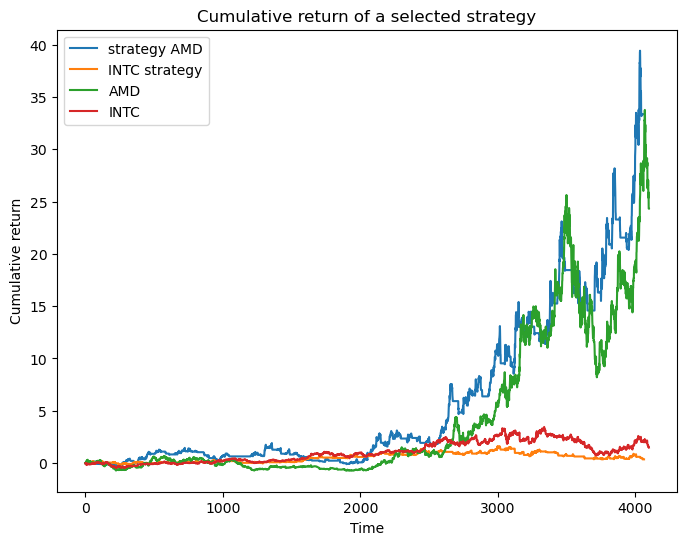

In [91]:
fig,ax=plt.subplots(figsize=(8,6))
startegy_cumulative_return_AMD=np.cumprod(1+strategies['AMD'][0][6])-1
startegy_cumulative_return_INTC=np.cumprod(1+strategies['INTC'][0][6])-1

ax.plot(startegy_cumulative_return_AMD,label='strategy AMD')
ax.plot(startegy_cumulative_return_INTC,label='INTC strategy')
ax.plot(stock['AMD']['Cumulatuive return'].values,label='AMD')
ax.plot(stock['INTC']['Cumulatuive return'].values,label='INTC')
ax.set_xlabel('Time')
ax.set_ylabel('Cumulative return')
ax.set_title('Cumulative return of a selected strategy')
ax.legend()
plt.show()

Visually, the AMD stock is much more volatile than INTC.\
'AMD' stock prices drop fatser  thus looking at the mean of prices on window A when A< B is more significant for 'AMD' than INTC as the strategy can detect faster these shift in AMD which probably results in higher returns than in INTC.

Let us compare these performances between the first half and second half of price history : 

In [92]:
stock_data_first_half={}
stock_data_second_half={}

for ticker in tickers:

    total_length=stock_data[ticker].shape[0]
    stock_data_first_half[ticker]=stock_data[ticker].iloc[:int(total_length/2)]
    stock_data_second_half[ticker]=stock_data[ticker].iloc[int(total_length/2):]

Performances on the first half: 

In [93]:
Performances_first_half ={}
for ticker in tickers:
    
    Performance_first_half,startegy = trend_following(ticker,Window_A, Window_B,stock_data=stock_data_first_half)
    Performances_first_half[ticker]=Performance_first_half

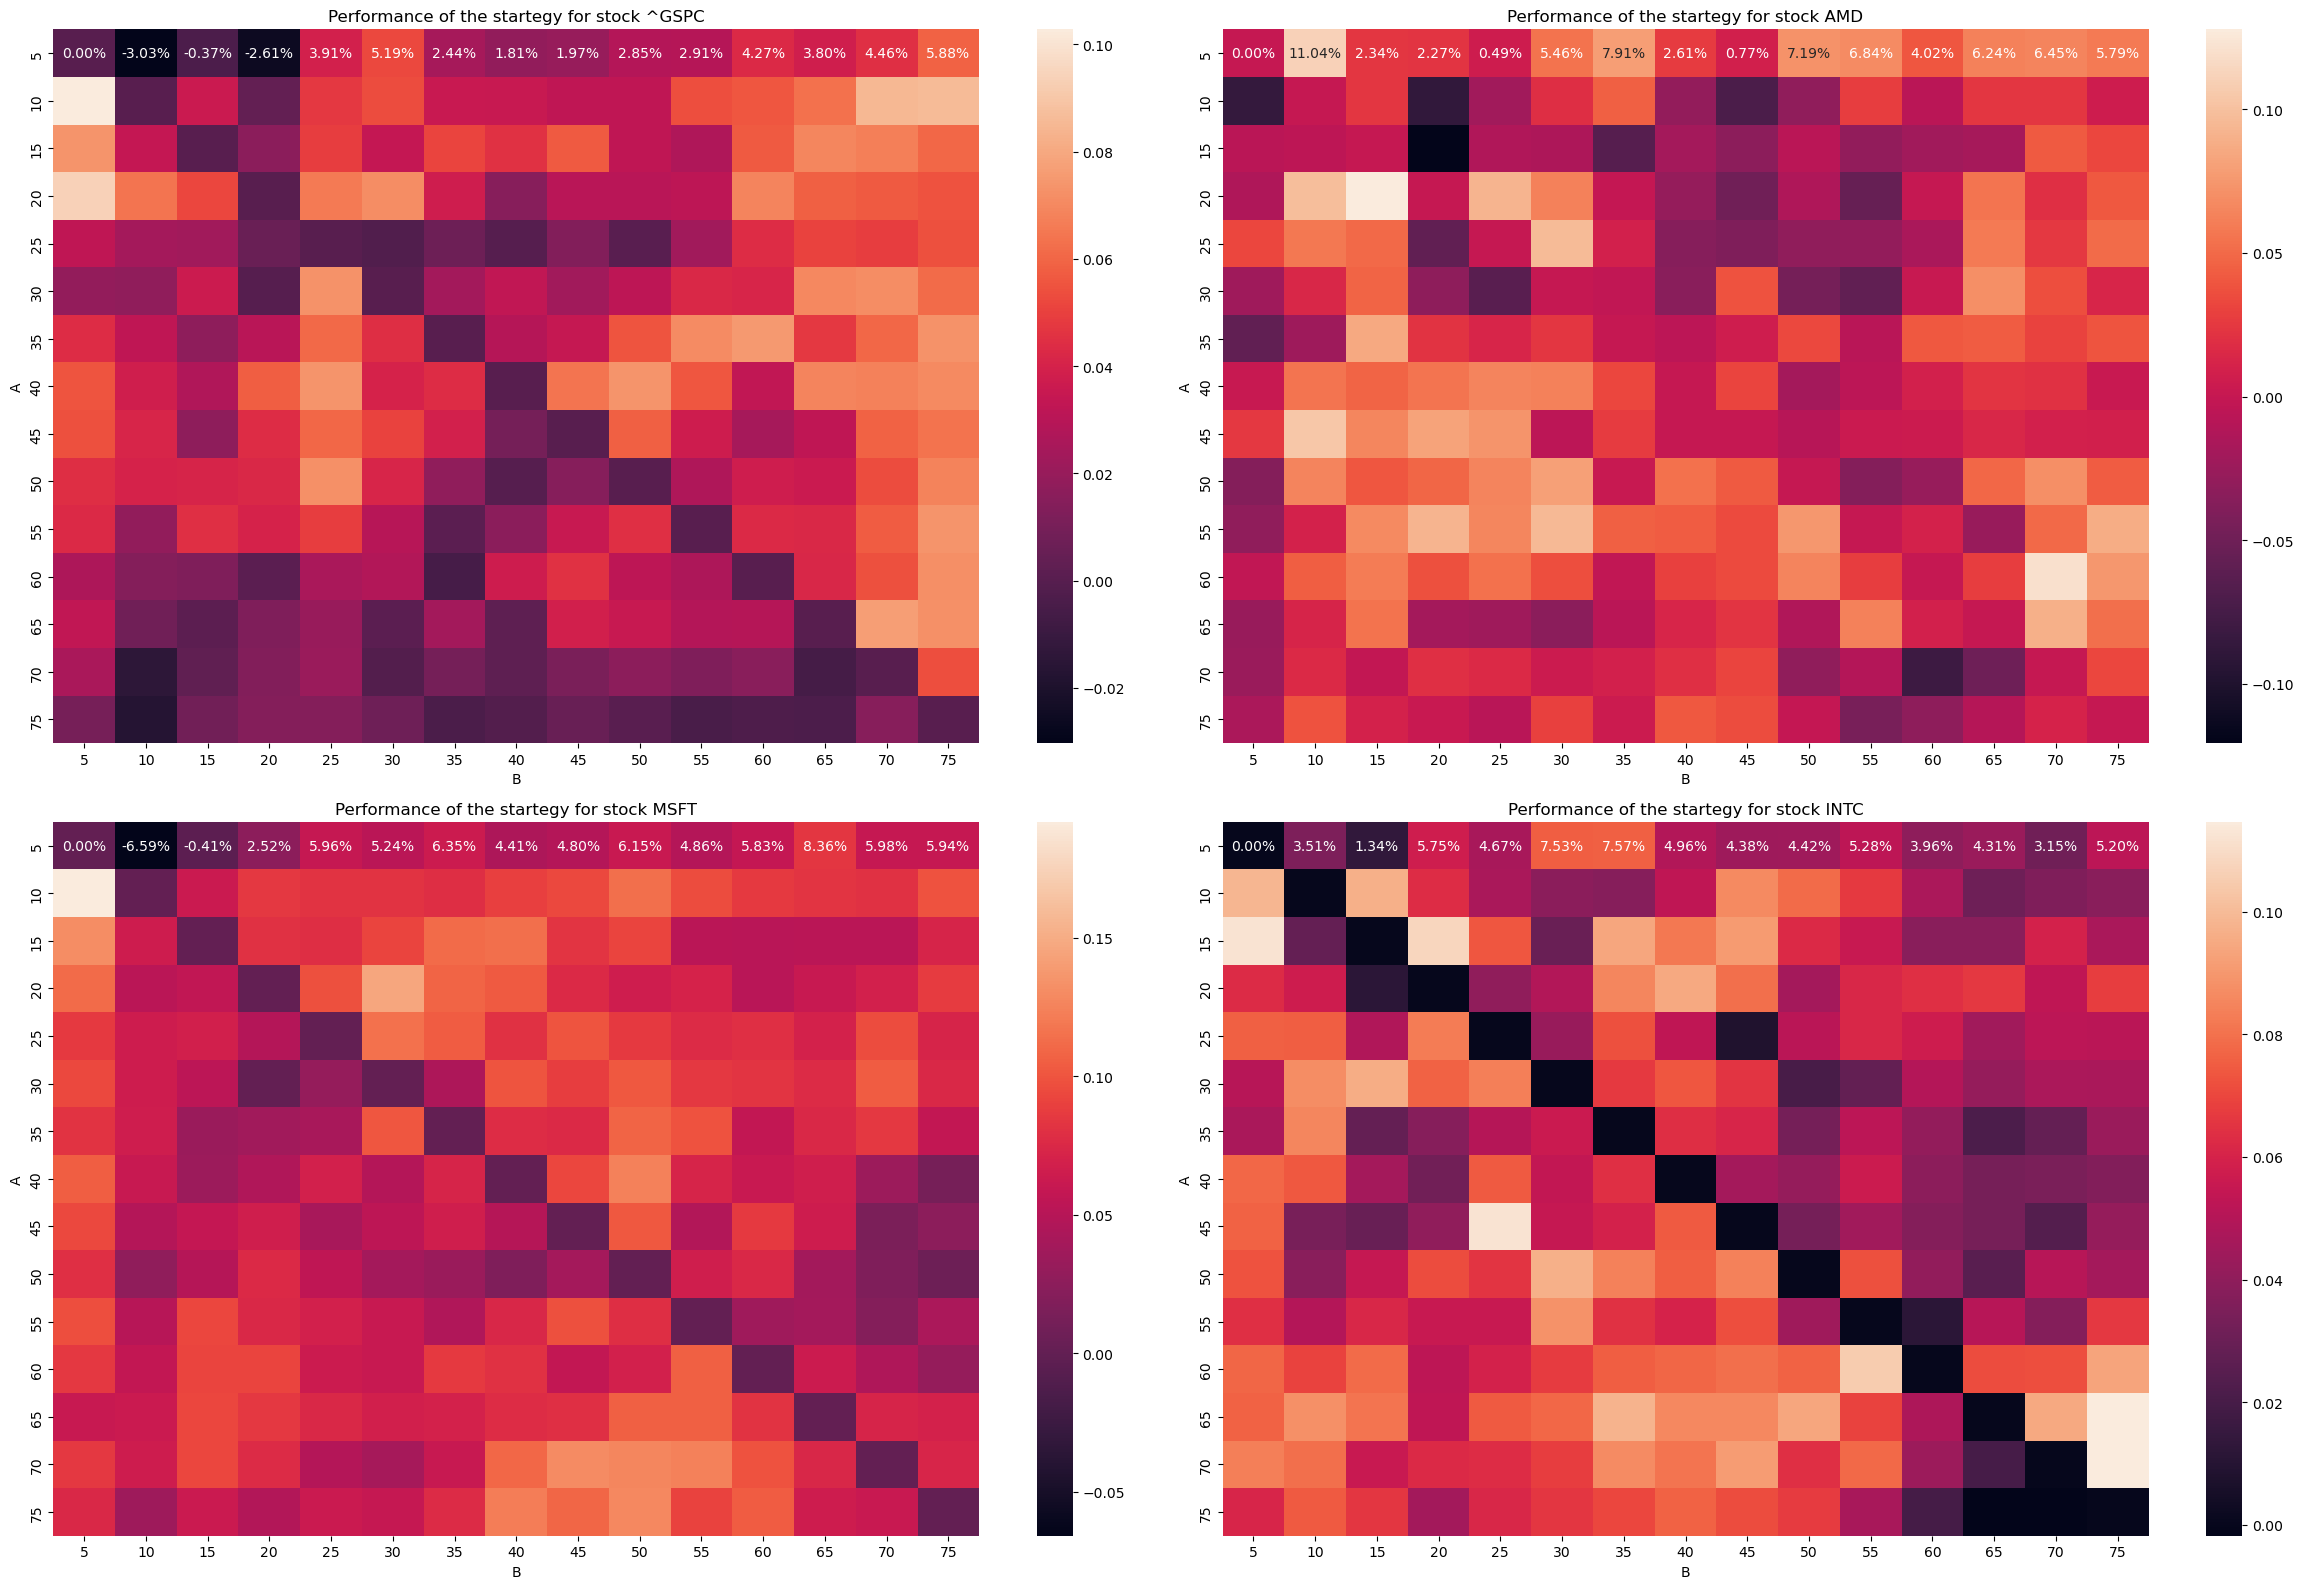

In [94]:
fig,ax=plt.subplots(2,2,figsize=(24,16))

for i in range(2):
    for j in range(2):
        
        ticker=tickers[i*2+j]
        sns.heatmap(Performances_first_half[ticker],ax=ax[i,j],annot=True,fmt='.2%',yticklabels=Window_A, xticklabels=Window_B)
        ax[i,j].set_xlabel('B')
        ax[i,j].set_ylabel('A')
        ax[i,j].set_title('Performance of the startegy for stock '+str(ticker))

plt.tight_layout()
plt.show()

Performances on the second half: 

In [95]:
Performances_second_half={}
for ticker in tickers:
    
    Performance_second_half,strategy = trend_following(ticker,Window_A, Window_B,stock_data=stock_data_second_half)
    Performances_second_half[ticker]=Performance_second_half

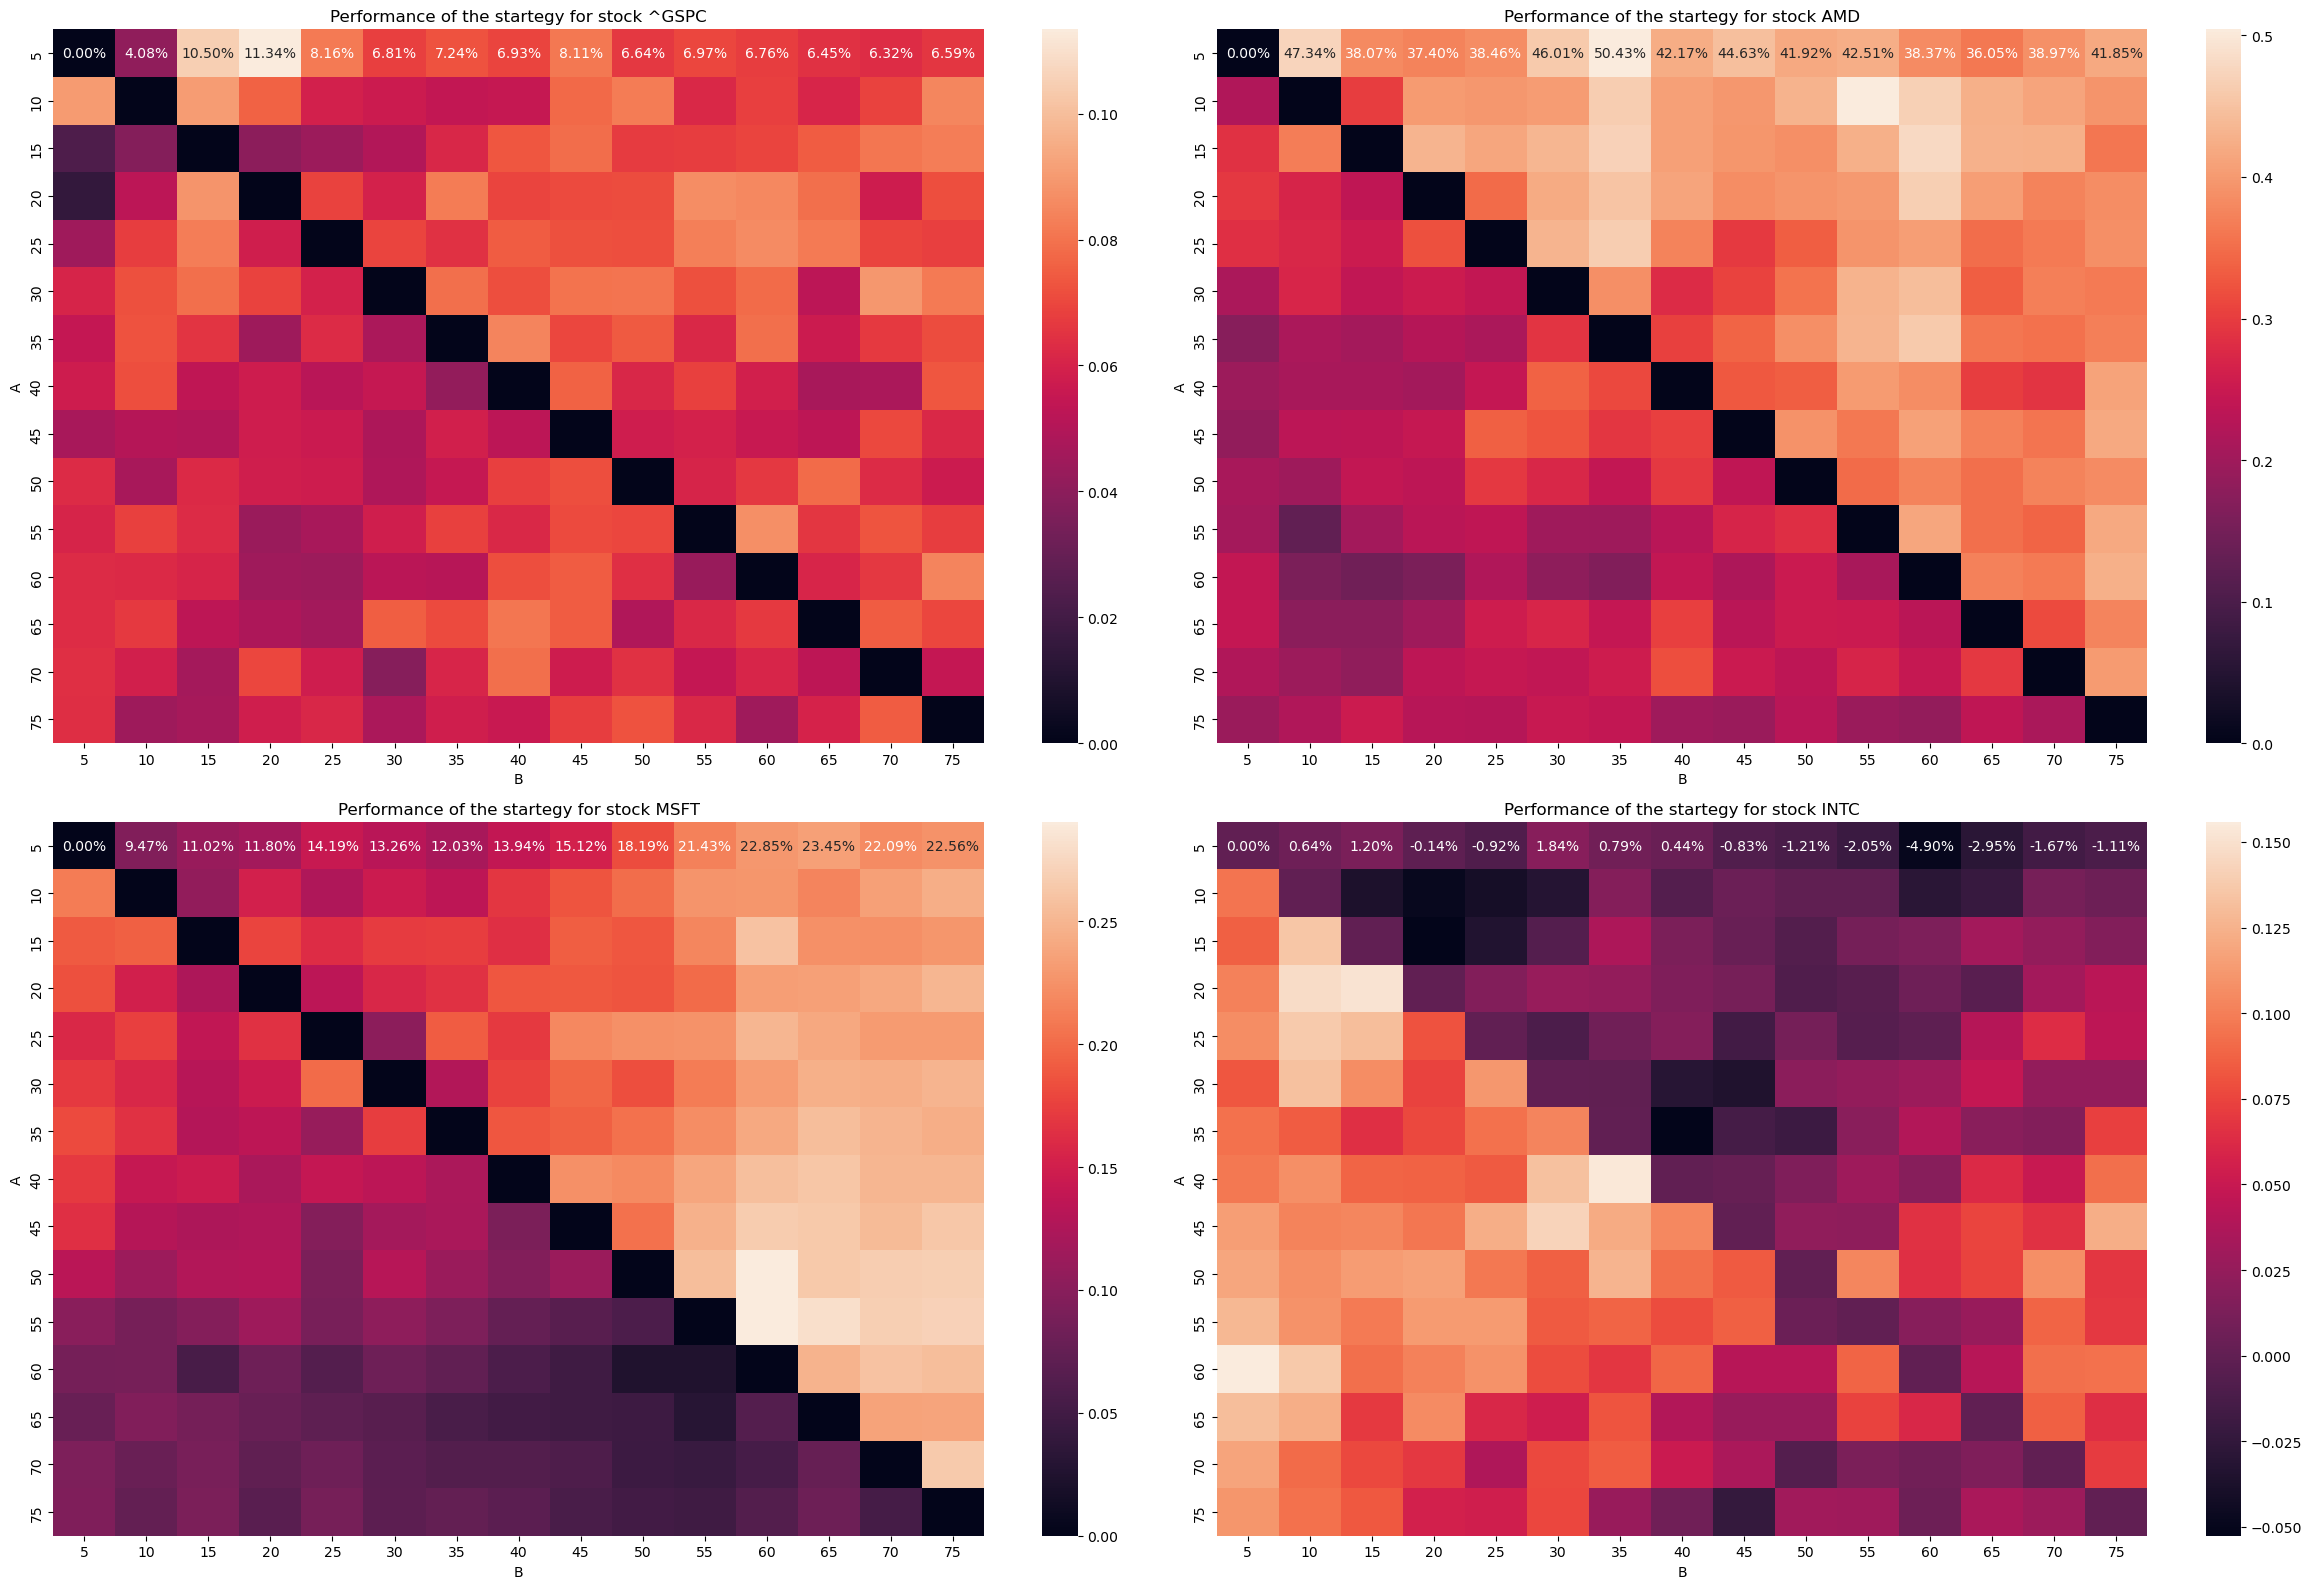

In [96]:
fig,ax=plt.subplots(2,2,figsize=(24,16))

for i in range(2):
    for j in range(2):

        ticker=tickers[i*2+j]
        sns.heatmap(Performances_second_half[ticker],ax=ax[i,j],annot=True,fmt='.2%',yticklabels=Window_A, xticklabels=Window_B)
        ax[i,j].set_xlabel('B')
        ax[i,j].set_ylabel('A')
        ax[i,j].set_title('Performance of the startegy for stock '+str(ticker))

plt.tight_layout()
plt.show()

Let us take the example of 'AMD' on the first half and on the second half :

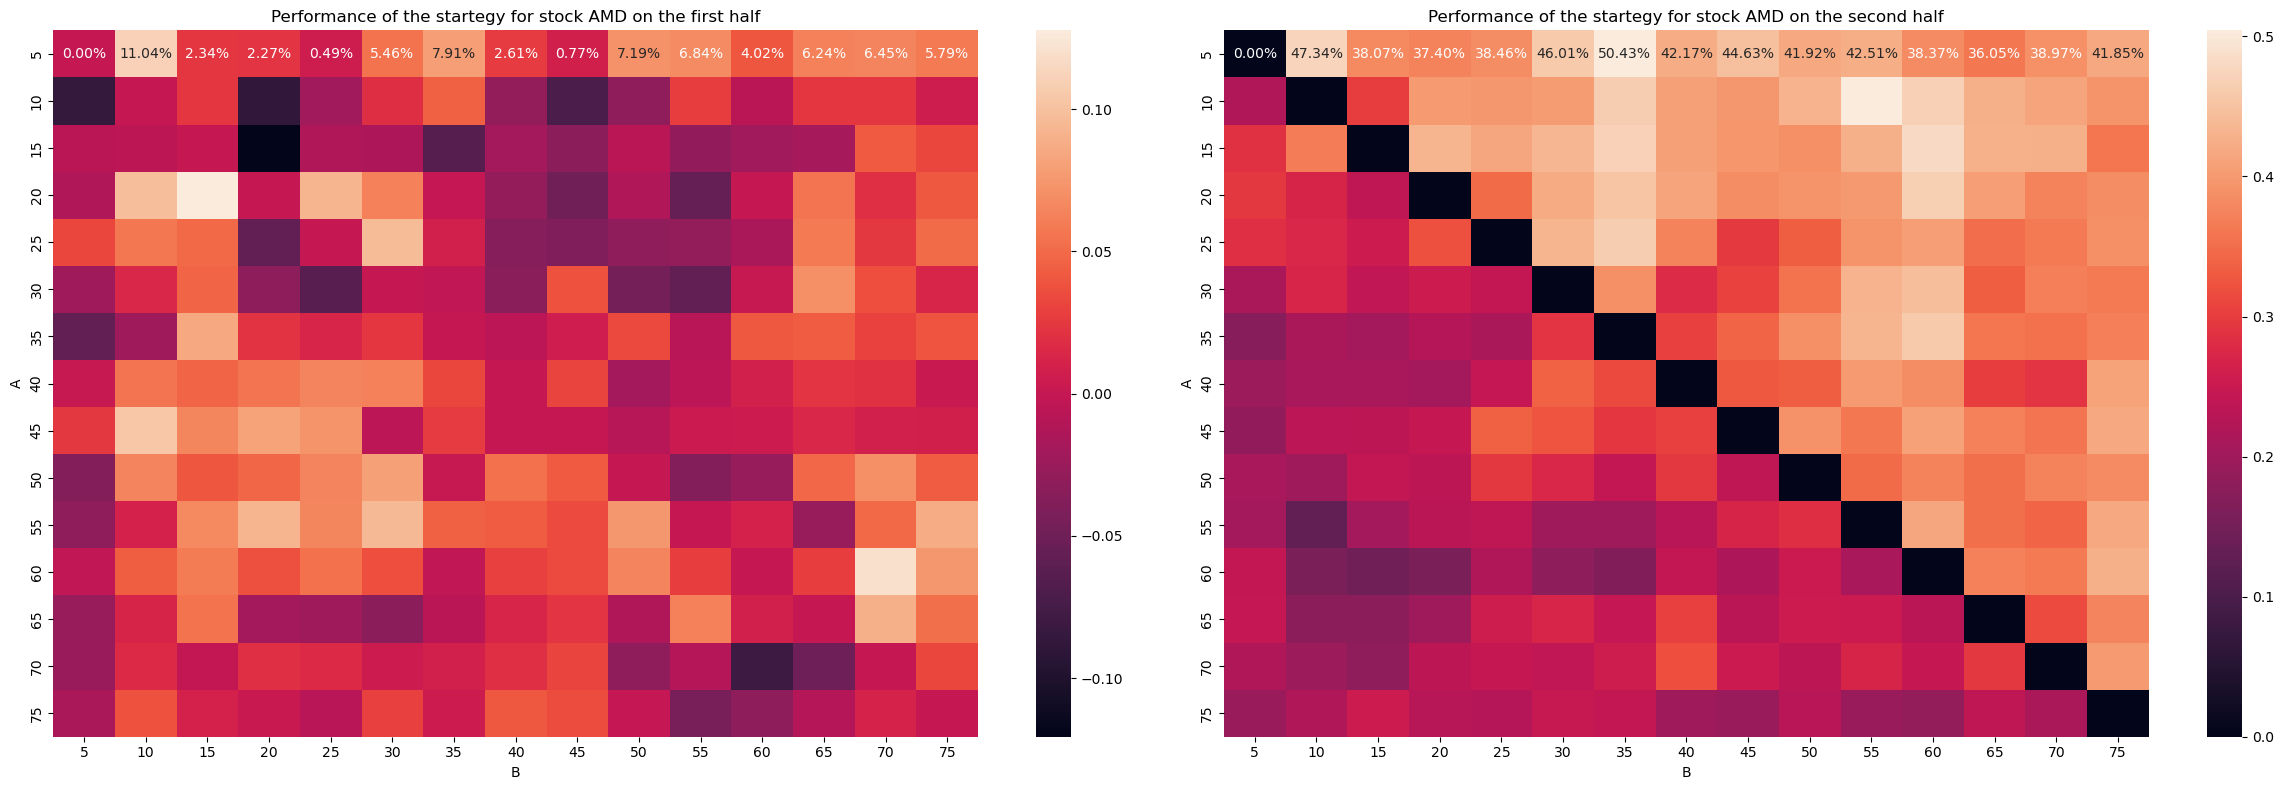

In [97]:
fig,ax=plt.subplots(1,2,figsize=(24,8))

sns.heatmap(Performances_first_half['AMD'],ax=ax[0],annot=True,fmt='.2%',yticklabels=Window_A, xticklabels=Window_B)
ax[0].set_xlabel('B')
ax[0].set_ylabel('A')
ax[0].set_title('Performance of the startegy for stock AMD on the first half')

sns.heatmap(Performances_second_half['AMD'],ax=ax[1],annot=True,fmt='.2%',yticklabels=Window_A, xticklabels=Window_B)
ax[1].set_xlabel('B')
ax[1].set_ylabel('A')
ax[1].set_title('Performance of the startegy for stock AMD on the second half')

plt.tight_layout()
plt.show()

By plotting the same graphs on the two halves of the history we notice that performance is not stationnary. for example the staretegy returns on AMD are much higher in the second half than in the first one. This is because the returns of the stock itself were much higher in the second half. We can thus deduce that performances of a strategy are not stationnary, they depend on the dynamics of the stock which can change with time.

## 2. Mean-reverting strategies

In [98]:
k_window=np.arange(2,10)
Vol_window=np.arange(2,20)

In [99]:
def Mean_reverting(ticker,k_window,Vol_Window,stock_data=stock_data):

    Performance = np.zeros((k_window.shape[0],Vol_Window.shape[0]))
    strategies  = []
    for i in range(k_window.shape[0]):
        strategies.append([])
        for j in range(Vol_Window.shape[0]):

            strategies[i].append([])
            k=k_window[i]
            Vol_window_length=Vol_Window[j]
            
            Stock = stock_data[ticker].copy()

            Stock['Mean_close'] = stock_data[ticker]['Close'].rolling(Vol_window_length).mean()
            Stock['Vol_close'] = stock_data[ticker]['Close'].rolling(Vol_window_length).std()

            Stock.dropna(inplace=True)

            Stock['Trade_sign'] = np.where(Stock['Close']-Stock['Mean_close'] > k*Stock['Vol_close'] , -1,1)
            Stock.loc[(Stock['Close'] - Stock['Mean_close'] > -k * Stock['Vol_close']) & (Stock['Close'] - Stock['Mean_close'] < 0), 'Trade_sign'] = -1

            Stock['Trade_sign']=Stock['Trade_sign'].shift(1)
            Stock['Strategy_Return'] = (Stock['Close'] - Stock['Close'].shift(1)) / Stock['Close'].shift(1)
            Stock['Strategy_Return']*= Stock['Trade_sign']
            
            Stock.dropna(inplace=True)

            Performance[i,j]=Stock['Strategy_Return'].mean()*252
            strategies[i][j]=Stock['Strategy_Return'].values

    return Performance,strategies

In [100]:
Performances_MR ={}
strategies_MR={}
for ticker in tickers:
    
    Performance_MR,strategy_MR = Mean_reverting(ticker,k_window,Vol_window)
    Performances_MR[ticker]=Performance_MR
    strategies_MR[ticker]=strategy_MR

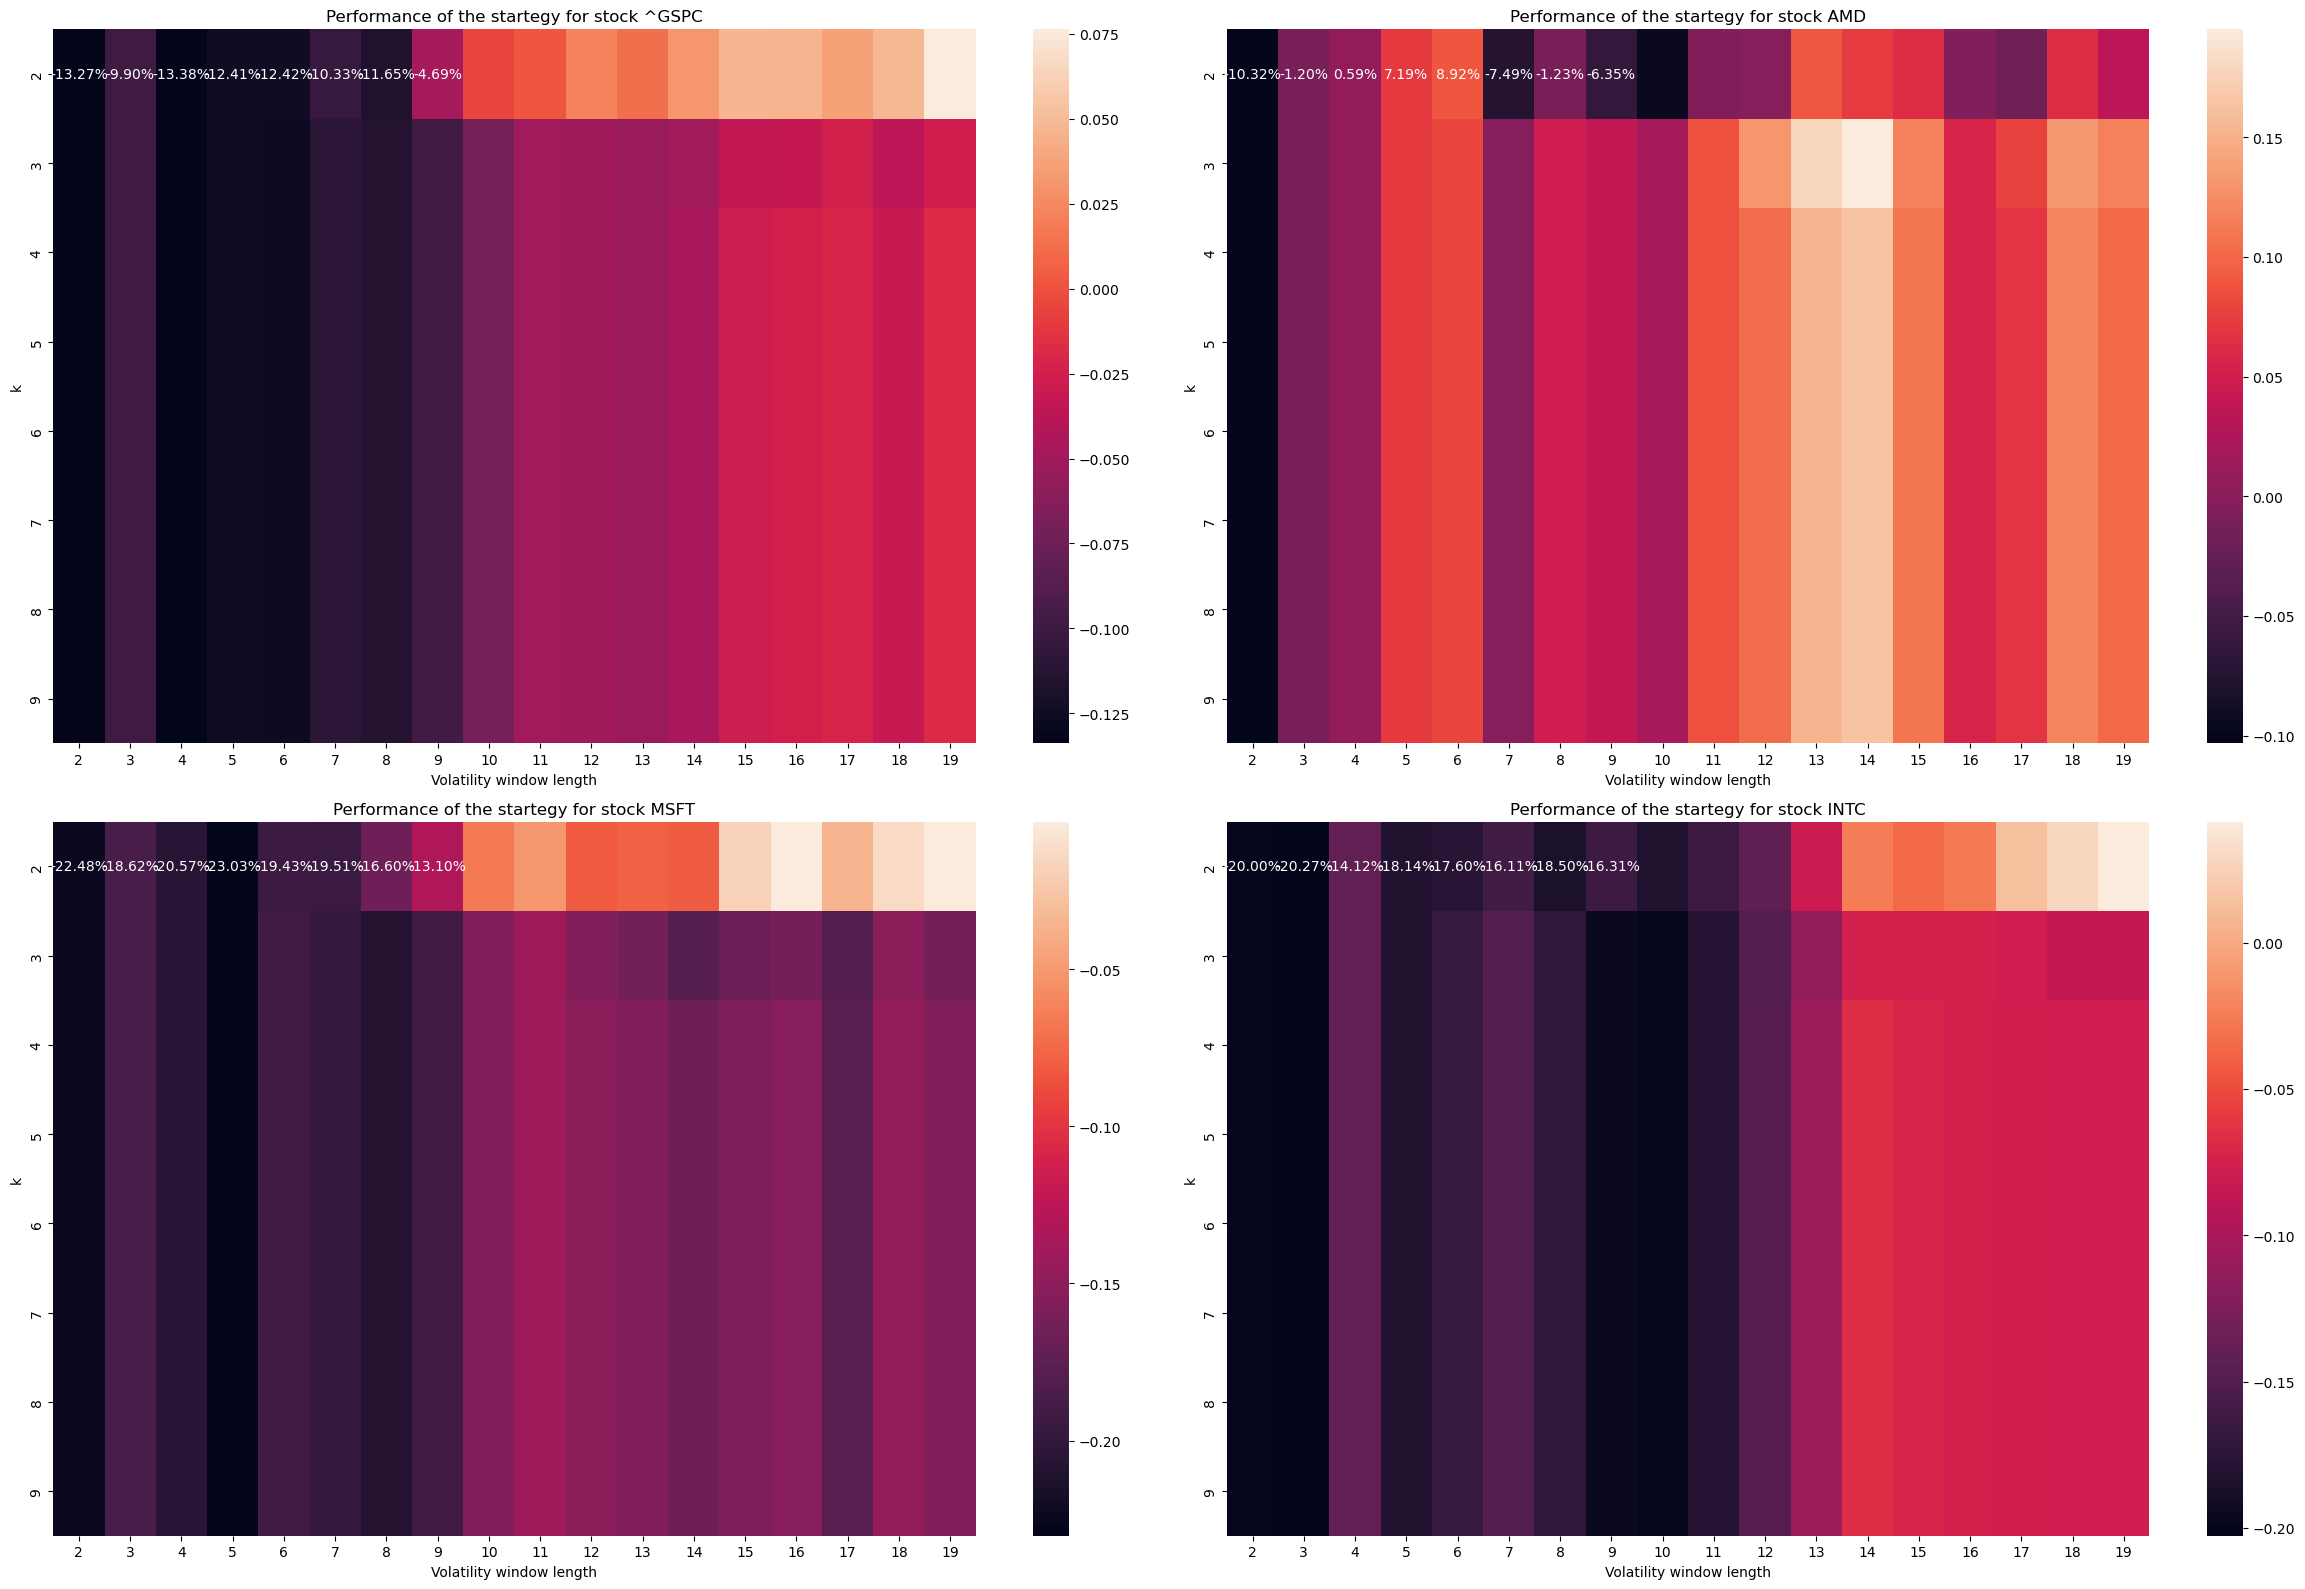

In [101]:
fig,ax=plt.subplots(2,2,figsize=(24,16))

for i in range(2):
    for j in range(2):

        
        ticker=tickers[i*2+j]
        sns.heatmap(Performances_MR[ticker],ax=ax[i,j],annot=True,fmt='.2%',yticklabels=k_window, xticklabels=Vol_window)
        ax[i,j].set_xlabel('Volatility window length')
        ax[i,j].set_ylabel('k')
        ax[i,j].set_title('Performance of the startegy for stock '+str(ticker))

plt.tight_layout()
plt.show()

As in the previous case, performance of the strategy varies from stock to another.\
Howerever in general performance of this strategy has shown overral low returns.Indeed some stocks (for example tech companies stocks) have an upword tendancy for a long time it is thus not very reasonable to short them.

We notice here that the performance depends mainly on the rolling window. actually from a certain value of k we notice little change in the strategy's performance as a function of k.\
This can be explained by the fact that froma certain value of k we are deep down the tail of the distribution, meaning that it is rare to hit the cap that would triger the action of the mean-reverting strategy.

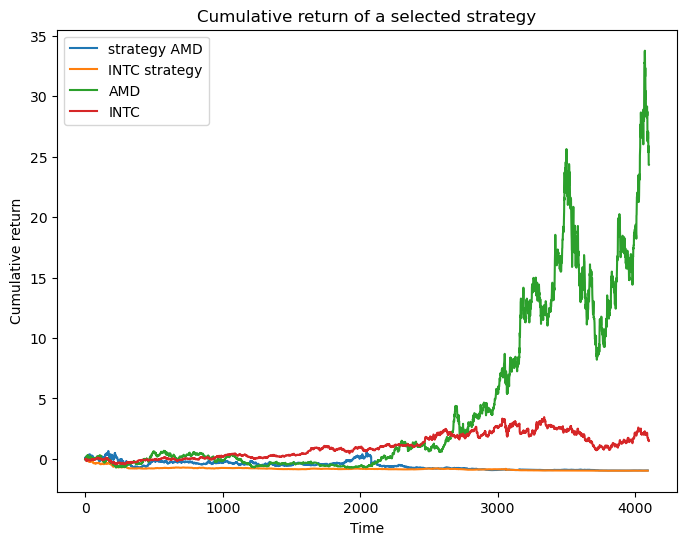

In [102]:
fig,ax=plt.subplots(figsize=(8,6))
startegy_cumulative_return_AMD=np.cumprod(1+strategies_MR['AMD'][0][6])-1
startegy_cumulative_return_INTC=np.cumprod(1+strategies_MR['INTC'][0][6])-1

ax.plot(startegy_cumulative_return_AMD,label='strategy AMD')
ax.plot(startegy_cumulative_return_INTC,label='INTC strategy')
ax.plot(stock['AMD']['Cumulatuive return'].values,label='AMD')
ax.plot(stock['INTC']['Cumulatuive return'].values,label='INTC')
ax.set_xlabel('Time')
ax.set_ylabel('Cumulative return')
ax.set_title('Cumulative return of a selected strategy')
ax.legend()
plt.show()

As mentioned above the performance of this strategy is very low. This could be due to that fact that we allow shorting stocks in this strategy which induces a high risk.

Let us compare these performances between the first half and the second half of prices history

Performances on the first half:

In [103]:
Performances_MR_first_half ={}
for ticker in tickers:
    
    Performance_MR_first_half,startegy = Mean_reverting(ticker,k_window,Vol_window,stock_data=stock_data_first_half)
    Performances_MR_first_half[ticker]=Performance_MR_first_half

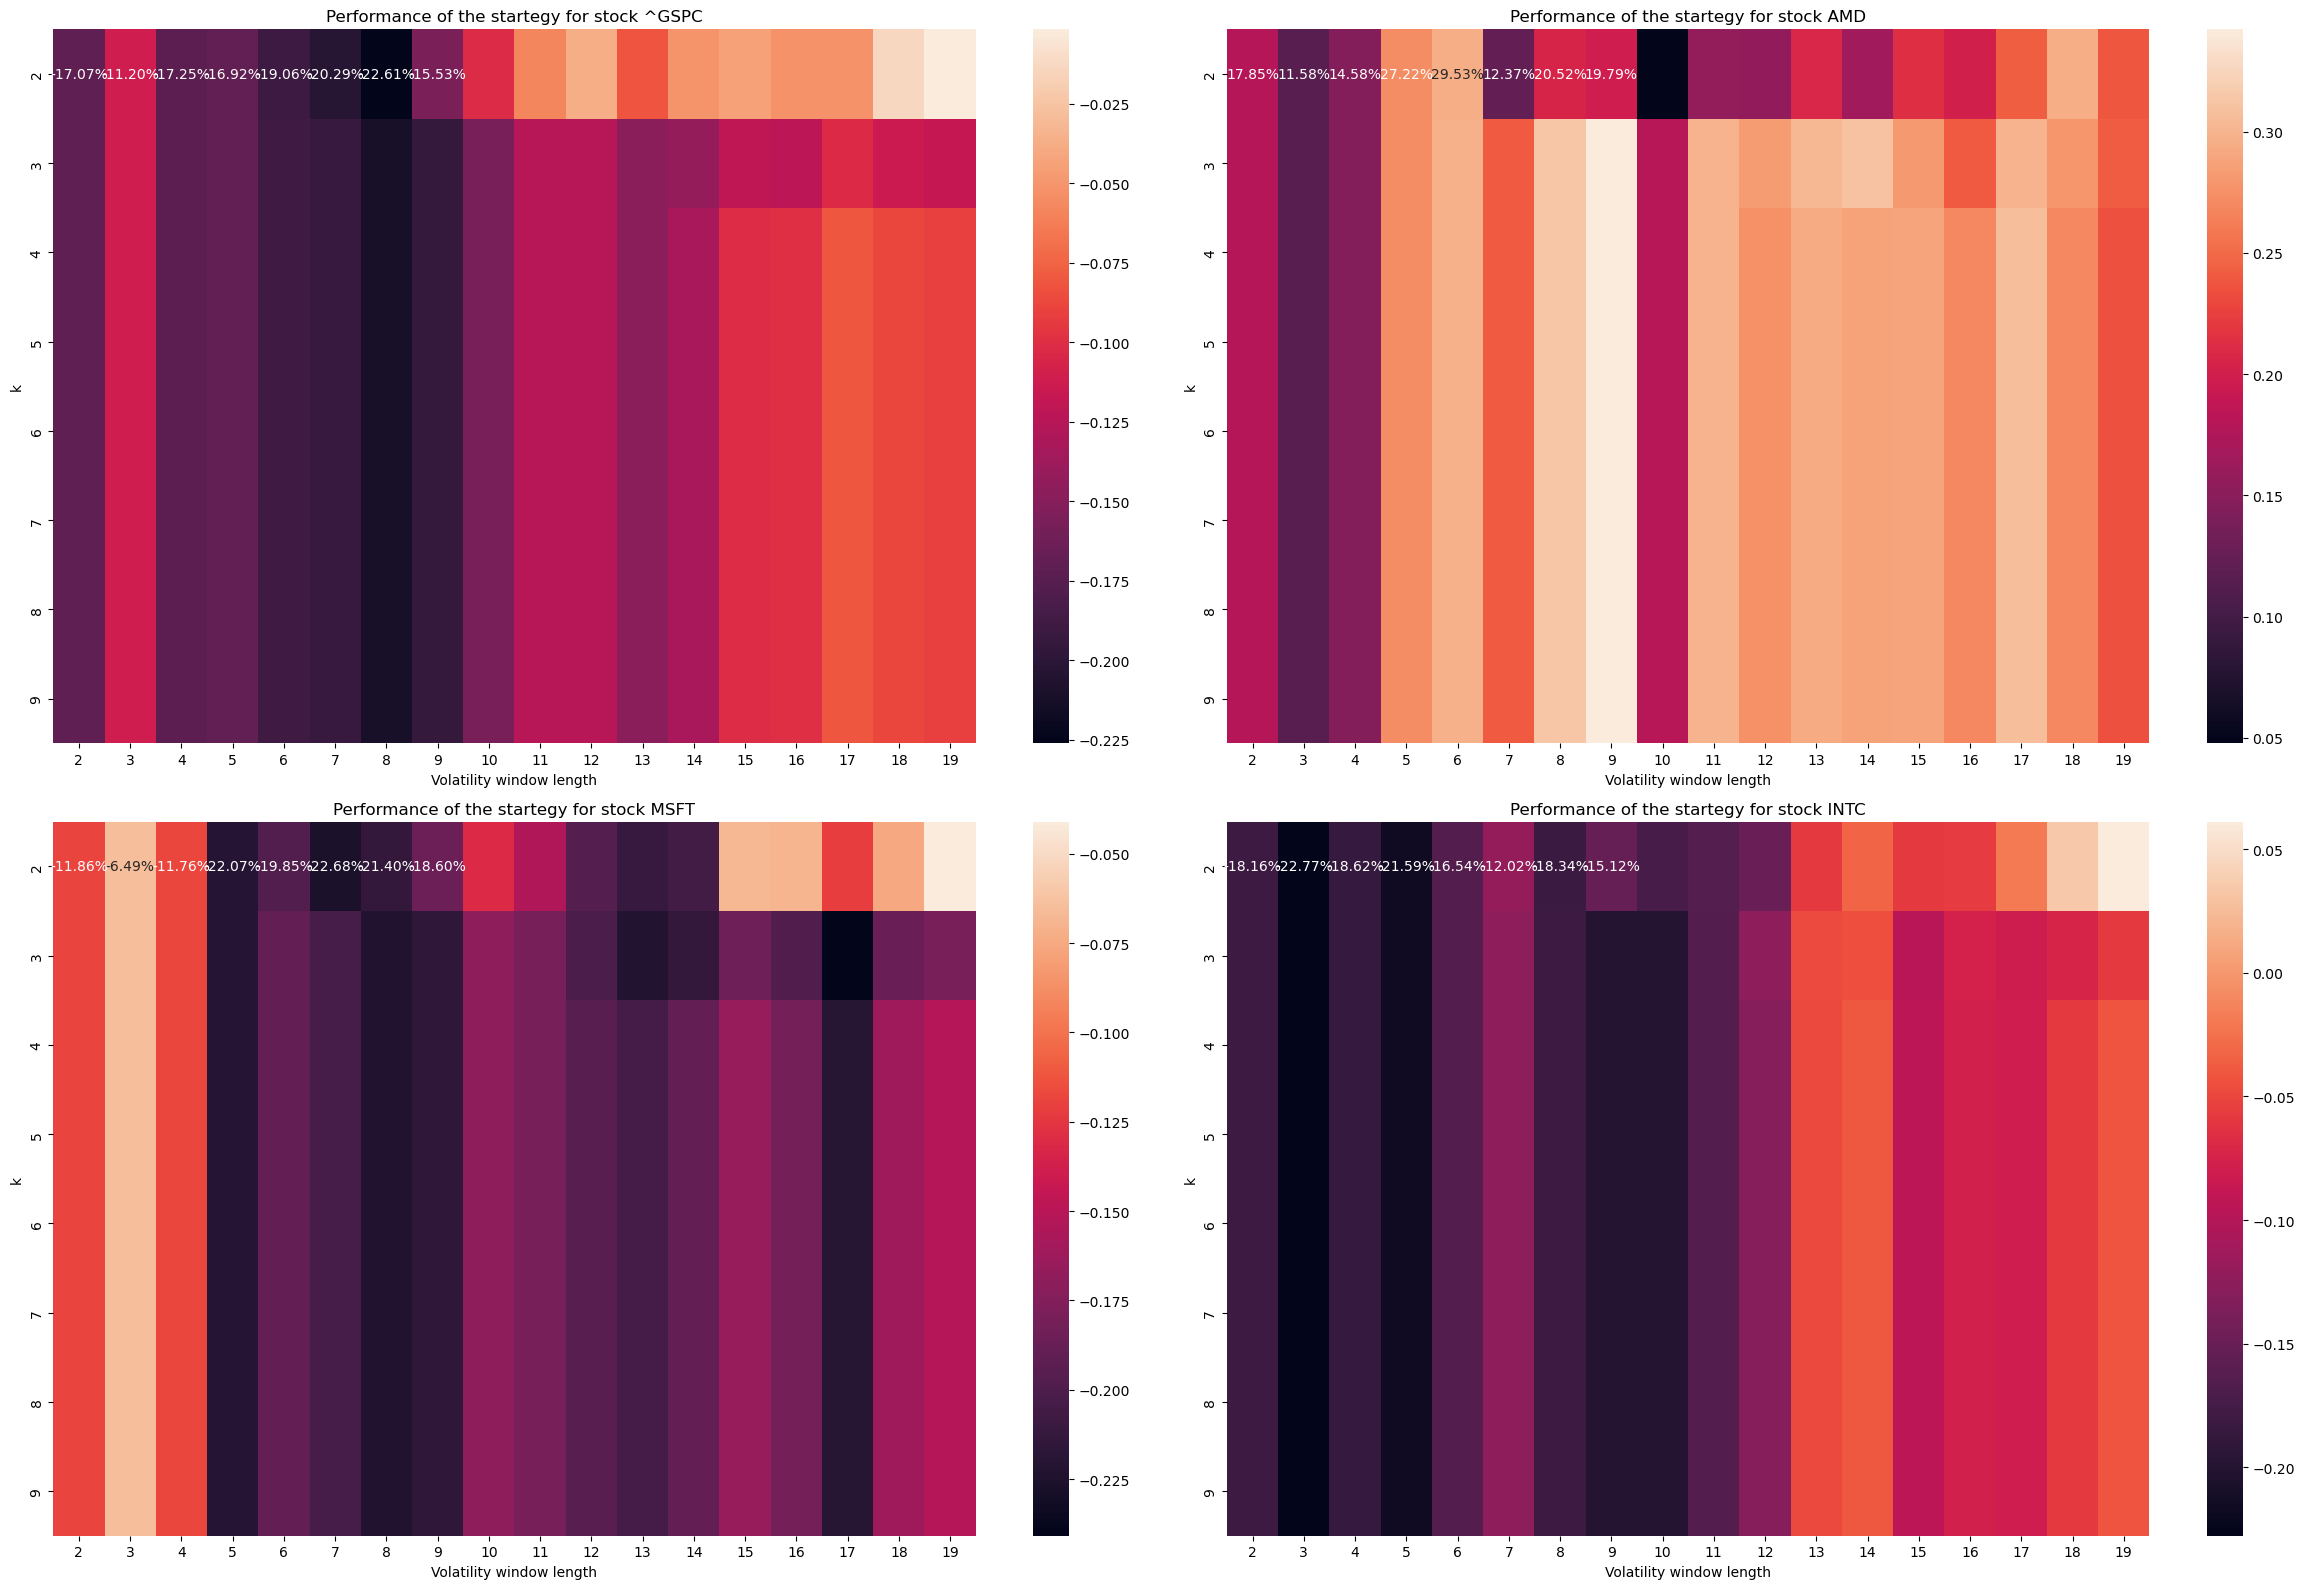

In [104]:
fig,ax=plt.subplots(2,2,figsize=(24,16))

for i in range(2):
    for j in range(2):
        
        ticker=tickers[i*2+j]
        sns.heatmap(Performances_MR_first_half[ticker],ax=ax[i,j],annot=True,fmt='.2%',yticklabels=k_window, xticklabels=Vol_window)
        ax[i,j].set_xlabel('Volatility window length')
        ax[i,j].set_ylabel('k')
        ax[i,j].set_title('Performance of the startegy for stock '+str(ticker))

plt.tight_layout()
plt.show()

On the second half : 

In [105]:
Performances_MR_second_half={}
for ticker in tickers:
    
    Performance_MR_second_half,startegy = Mean_reverting(ticker,k_window,Vol_window,stock_data=stock_data_second_half)
    Performances_MR_second_half[ticker]=Performance_MR_second_half

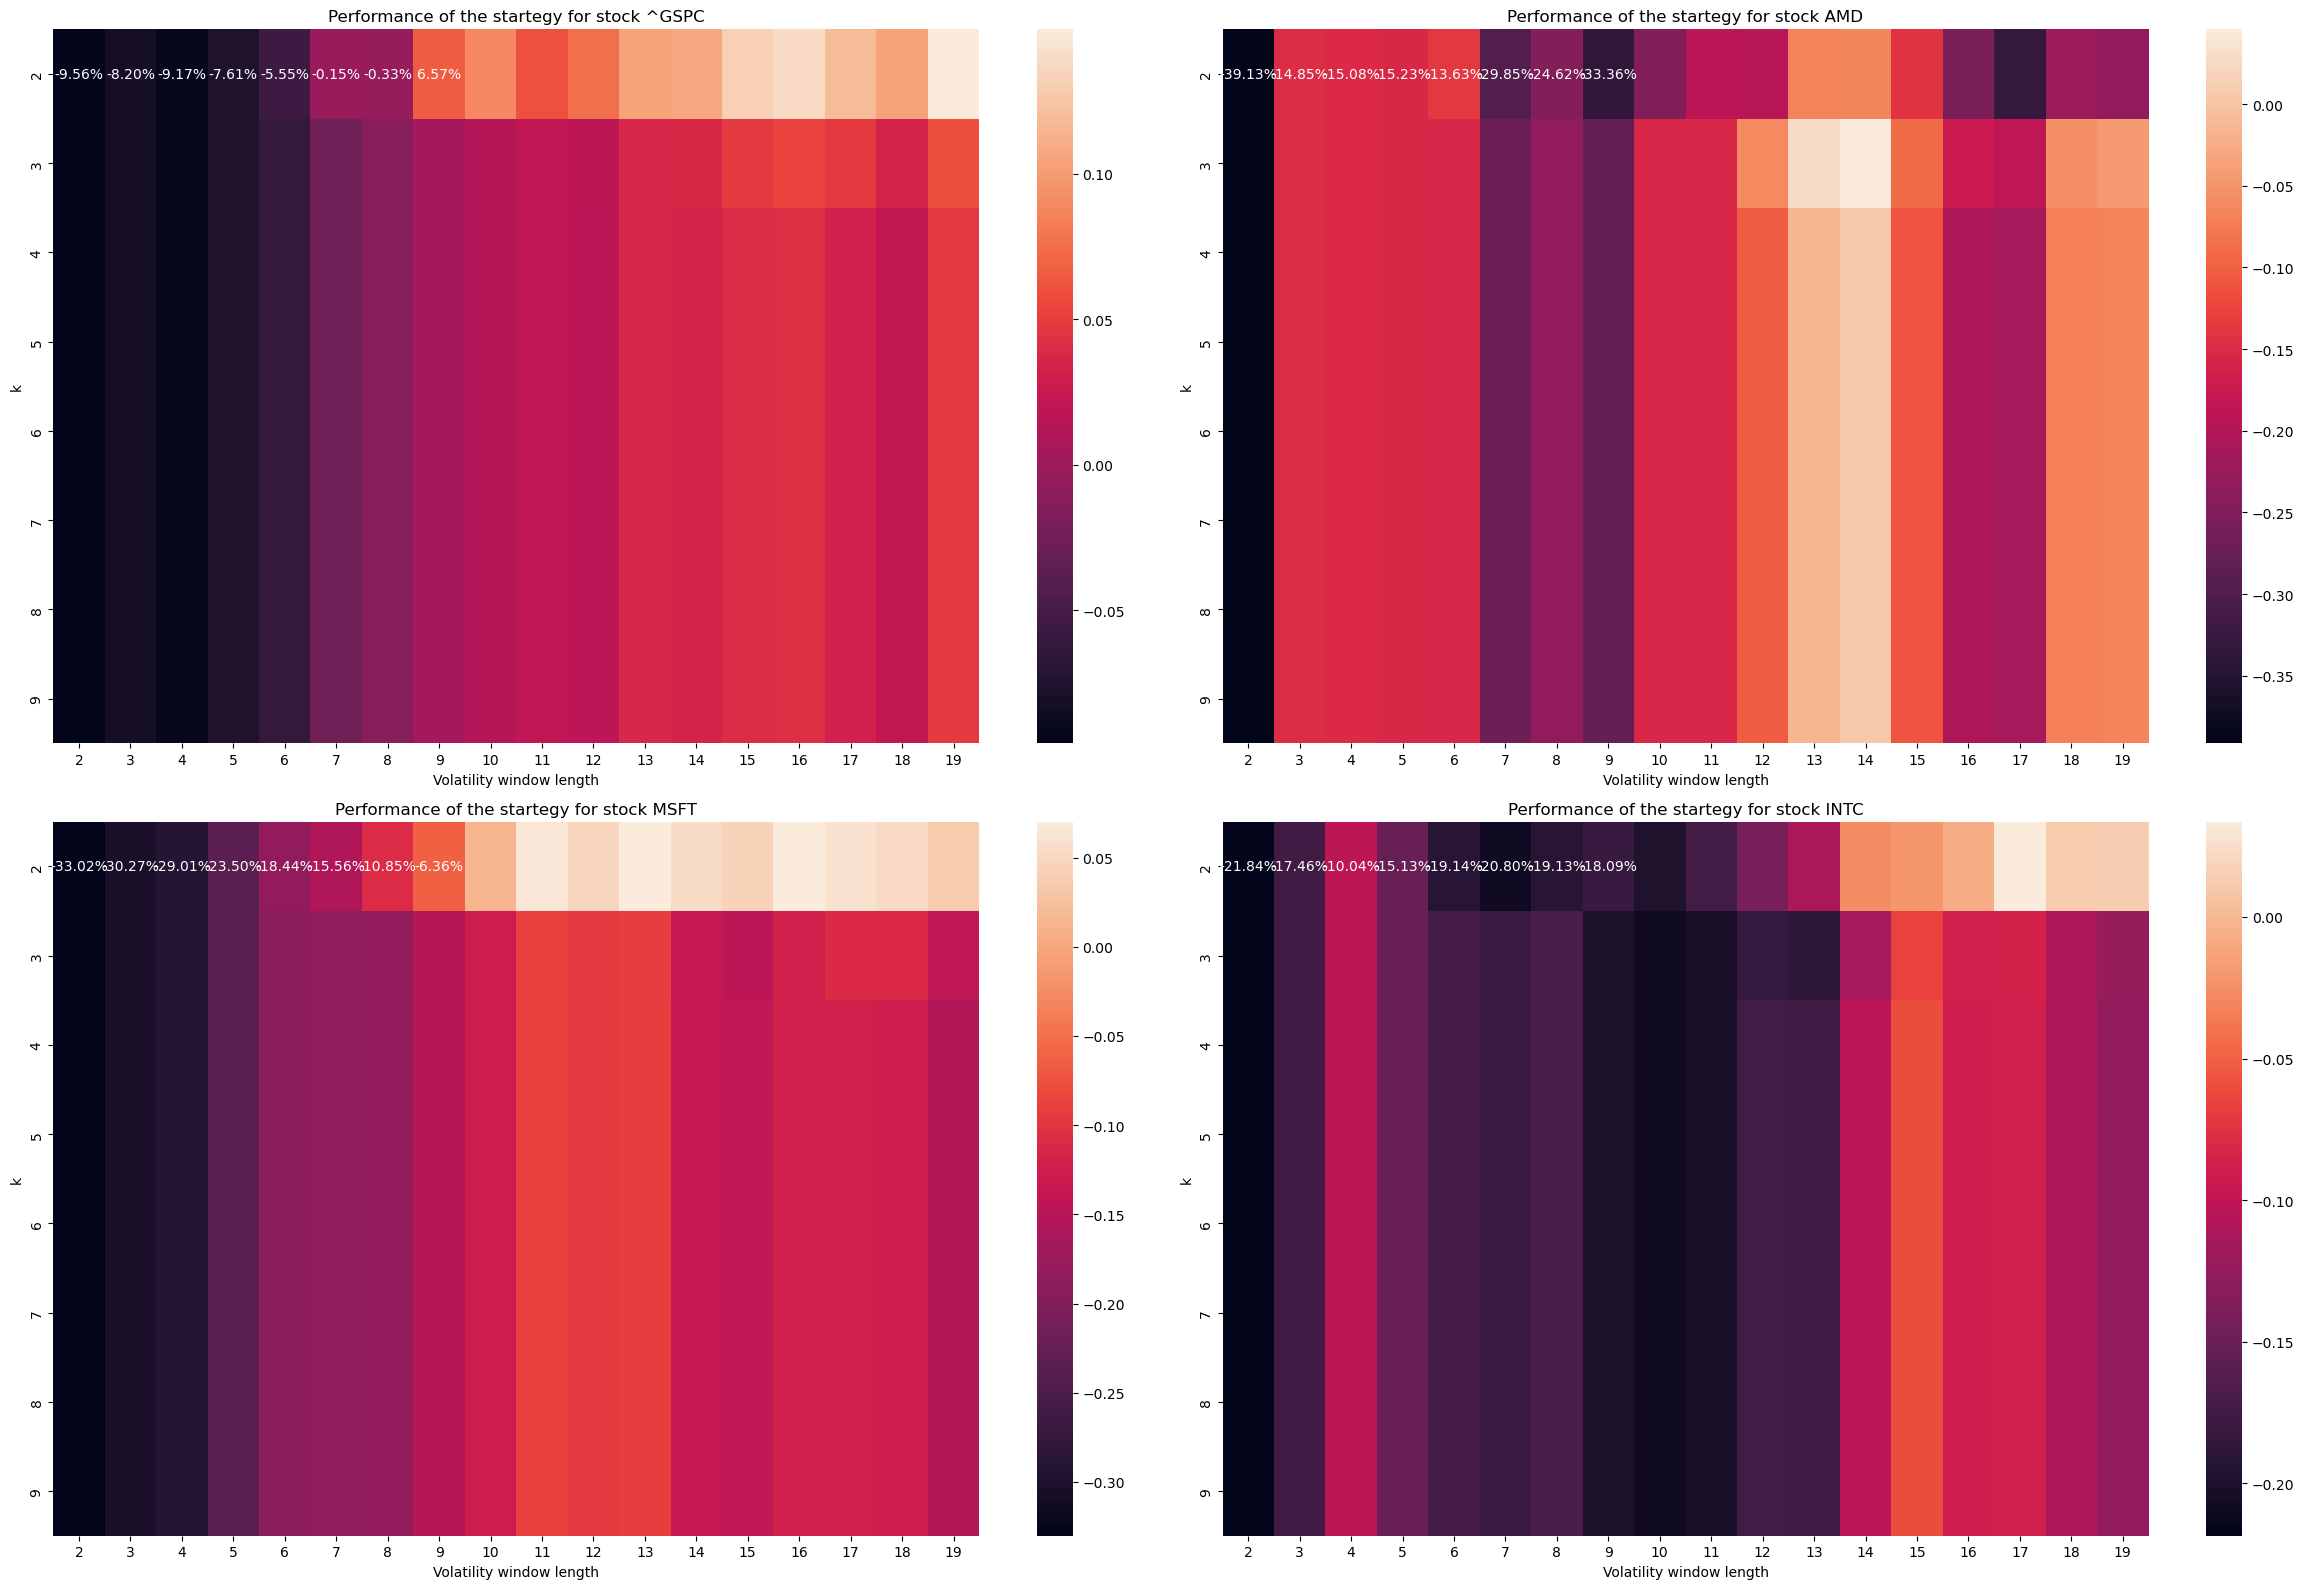

In [106]:
fig,ax=plt.subplots(2,2,figsize=(24,16))

for i in range(2):
    for j in range(2):
        
        ticker=tickers[i*2+j]
        sns.heatmap(Performances_MR_second_half[ticker],ax=ax[i,j],annot=True,fmt='.2%',yticklabels=k_window, xticklabels=Vol_window)
        ax[i,j].set_xlabel('Volatility window length')
        ax[i,j].set_ylabel('k')
        ax[i,j].set_title('Performance of the startegy for stock '+str(ticker))

plt.tight_layout()
plt.show()

Just like in the first case, the performance is not stationnary and it depends on the dynamics of the stock that changes with time.

## 3. Conditional strategies

In [107]:
tickers = ['JPM', 'BAC', 'RIO', 'BHP', 'AAPL', 'MSFT', 'GOOGL', 'AMZN', 'AMD', '^GSPC']
# Creating a dictionary to store data for each ticker
stock_data = {}

# Loading historical data for each ticker
for ticker in tickers:
    stock_data[ticker] = yf.Ticker(ticker).history(start='2006-01-01', auto_adjust=True)

In [108]:
def calculate_quantile(row, window):
    
    prev_log_returns = row[-window:]
    quantile = percentileofscore(prev_log_returns, row[-1])
    return quantile

In [109]:
Empirical_distribution_window=40

for ticker in tickers:

    stock_data[ticker]['Return'] = (stock_data[ticker]['Close'] - stock_data[ticker]['Close'].shift(1)) / stock_data[ticker]['Close'].shift(1)
    stock_data[ticker].dropna(inplace=True)
    
    stock_data[ticker]['Quantile'] = stock_data[ticker]['Return'].rolling(window=Empirical_distribution_window).apply(calculate_quantile, args=(Empirical_distribution_window,), raw=True)

We consider the following conditional strategy : 
- If the stocks' returns exceeds the 80% quantile (quantiles are calculated based on a rolling window of 40 days) we short-sell the stock as we believe that return is going to decrease in the following day.
- If the stocks' returns decreases bellow the 20% quantile (quantiles are calculated based on a rolling window of 40 days) we buy the stock as we believe that return is going to increase in the following day.
- If the stock's return is between the 50% quantile and the 80% quantile we buy the stock as we believe that return is going to continue increasing in the following day
- If the stock's return is between the 20% quantile the 50% quantile we short-sell the stock as we believe that return is going to continue increasing in the following day

In [117]:
def Conditional_strategy(ticker,Lower_treshhold,Upper_treshhold,stock_data=stock_data):
    
    Stock = stock_data[ticker].copy()
    
    Stock['Trade_sign'] = np.where(Stock['Quantile'] > Upper_treshhold , -1, 1)
    Stock.loc[(Stock['Quantile'] > Lower_treshhold ) & (Stock['Quantile'] < 50), 'Trade_sign'] = -1
    Stock['Strategy_Return'] = Stock['Return']
    Stock['Trade_sign']= Stock['Trade_sign'].shift(1)
    Stock.dropna(inplace=True)
    Stock['Strategy_Return'] *= Stock['Trade_sign']
    
    Performance=Stock['Strategy_Return']

    return Performance

In [118]:
Lower_treshhold=20
Upper_treshhold=80
Performance_conditional={}
for ticker in tickers:
    stock_data_year={}
    stock_data_year[ticker]=stock_data[ticker][stock_data[ticker].index.year==2023]
    Performance_conditional[ticker]=Conditional_strategy(ticker,Lower_treshhold,Upper_treshhold,stock_data=stock_data_year)

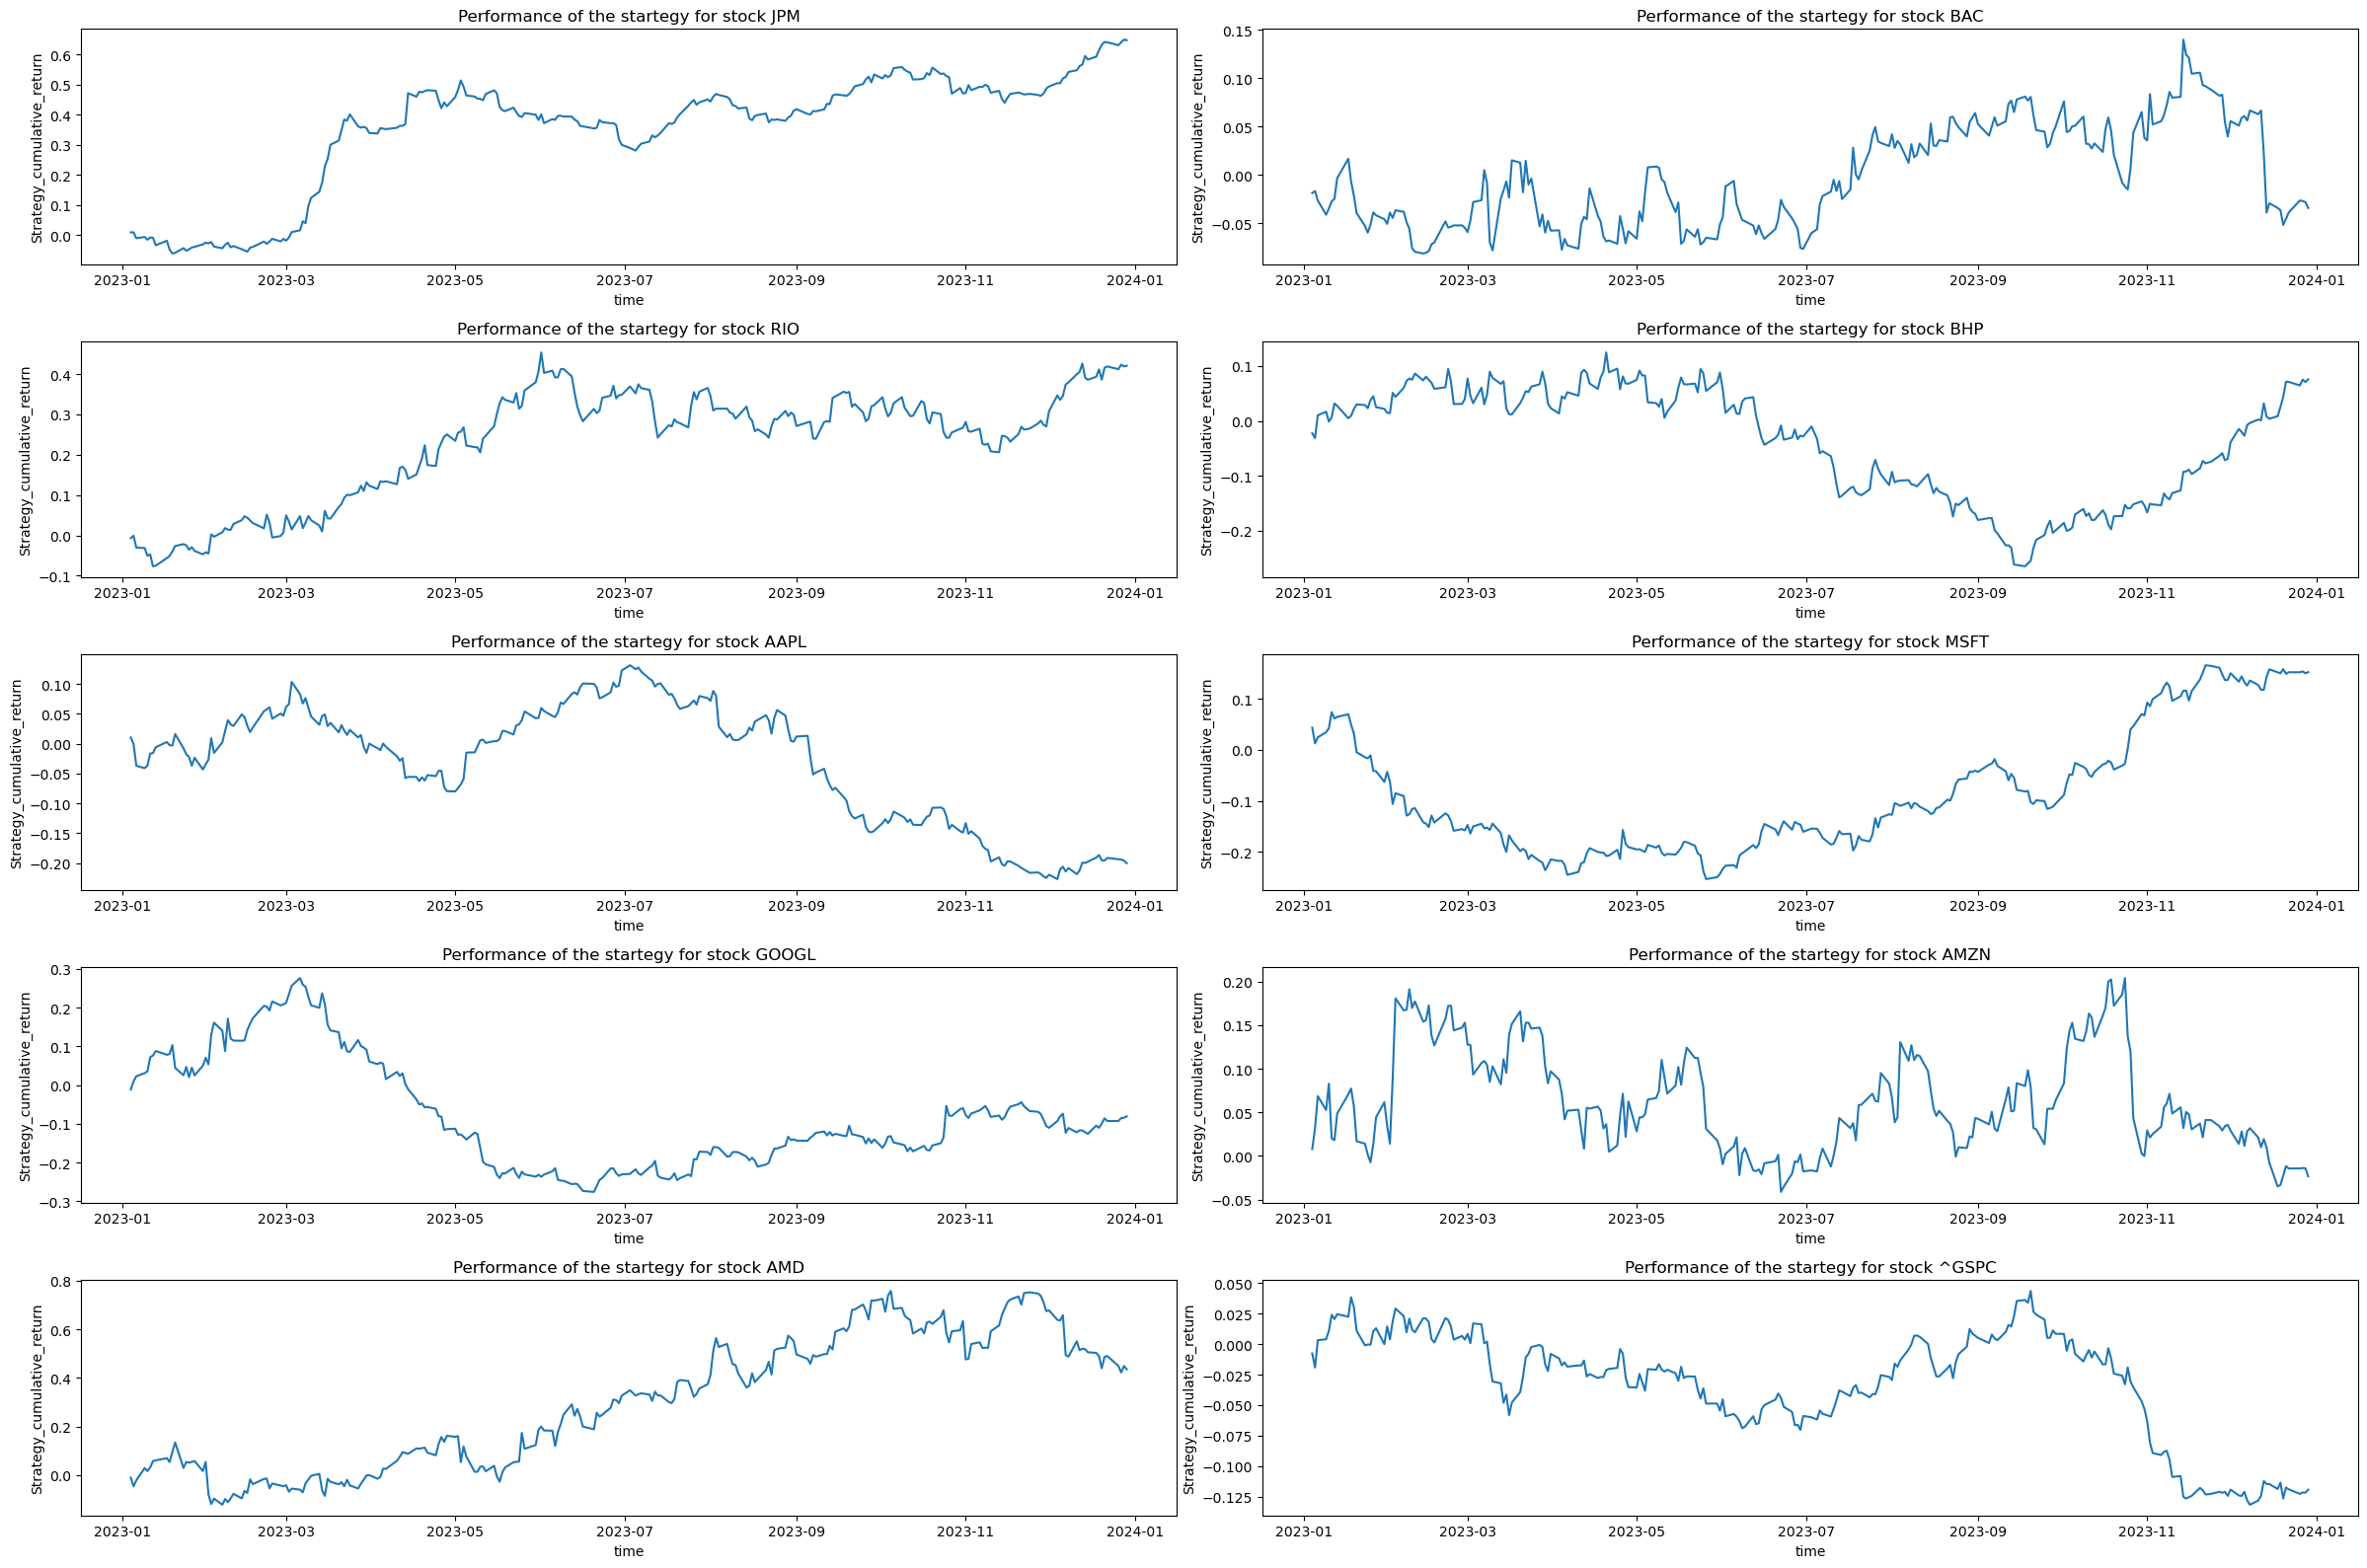

In [119]:
fig,ax=plt.subplots(5,2,figsize=(24,16))

for i in range(5):
    for j in range(2):
        
        ticker=tickers[i*2+j]
        cumultaive_Performance=np.cumprod(Performance_conditional[ticker]+1)-1
        ax[i,j].plot(cumultaive_Performance)
        ax[i,j].set_xlabel('time')
        ax[i,j].set_ylabel('Strategy_cumulative_return')
        ax[i,j].set_title('Performance of the startegy for stock '+str(ticker))

plt.tight_layout()
plt.show()

Performance of the strategy is not stable during time and its behaviour differs from one stock to another.

In [120]:
Monthly_avg_Performance=np.zeros((10,12))

for i in range(len(tickers)): 
    ticker=tickers[i]
    P=Performance_conditional[ticker].groupby([Performance_conditional[ticker].index.month,Performance_conditional[ticker].index.year]).mean()
    Monthly_avg_Performance[i]=P.values

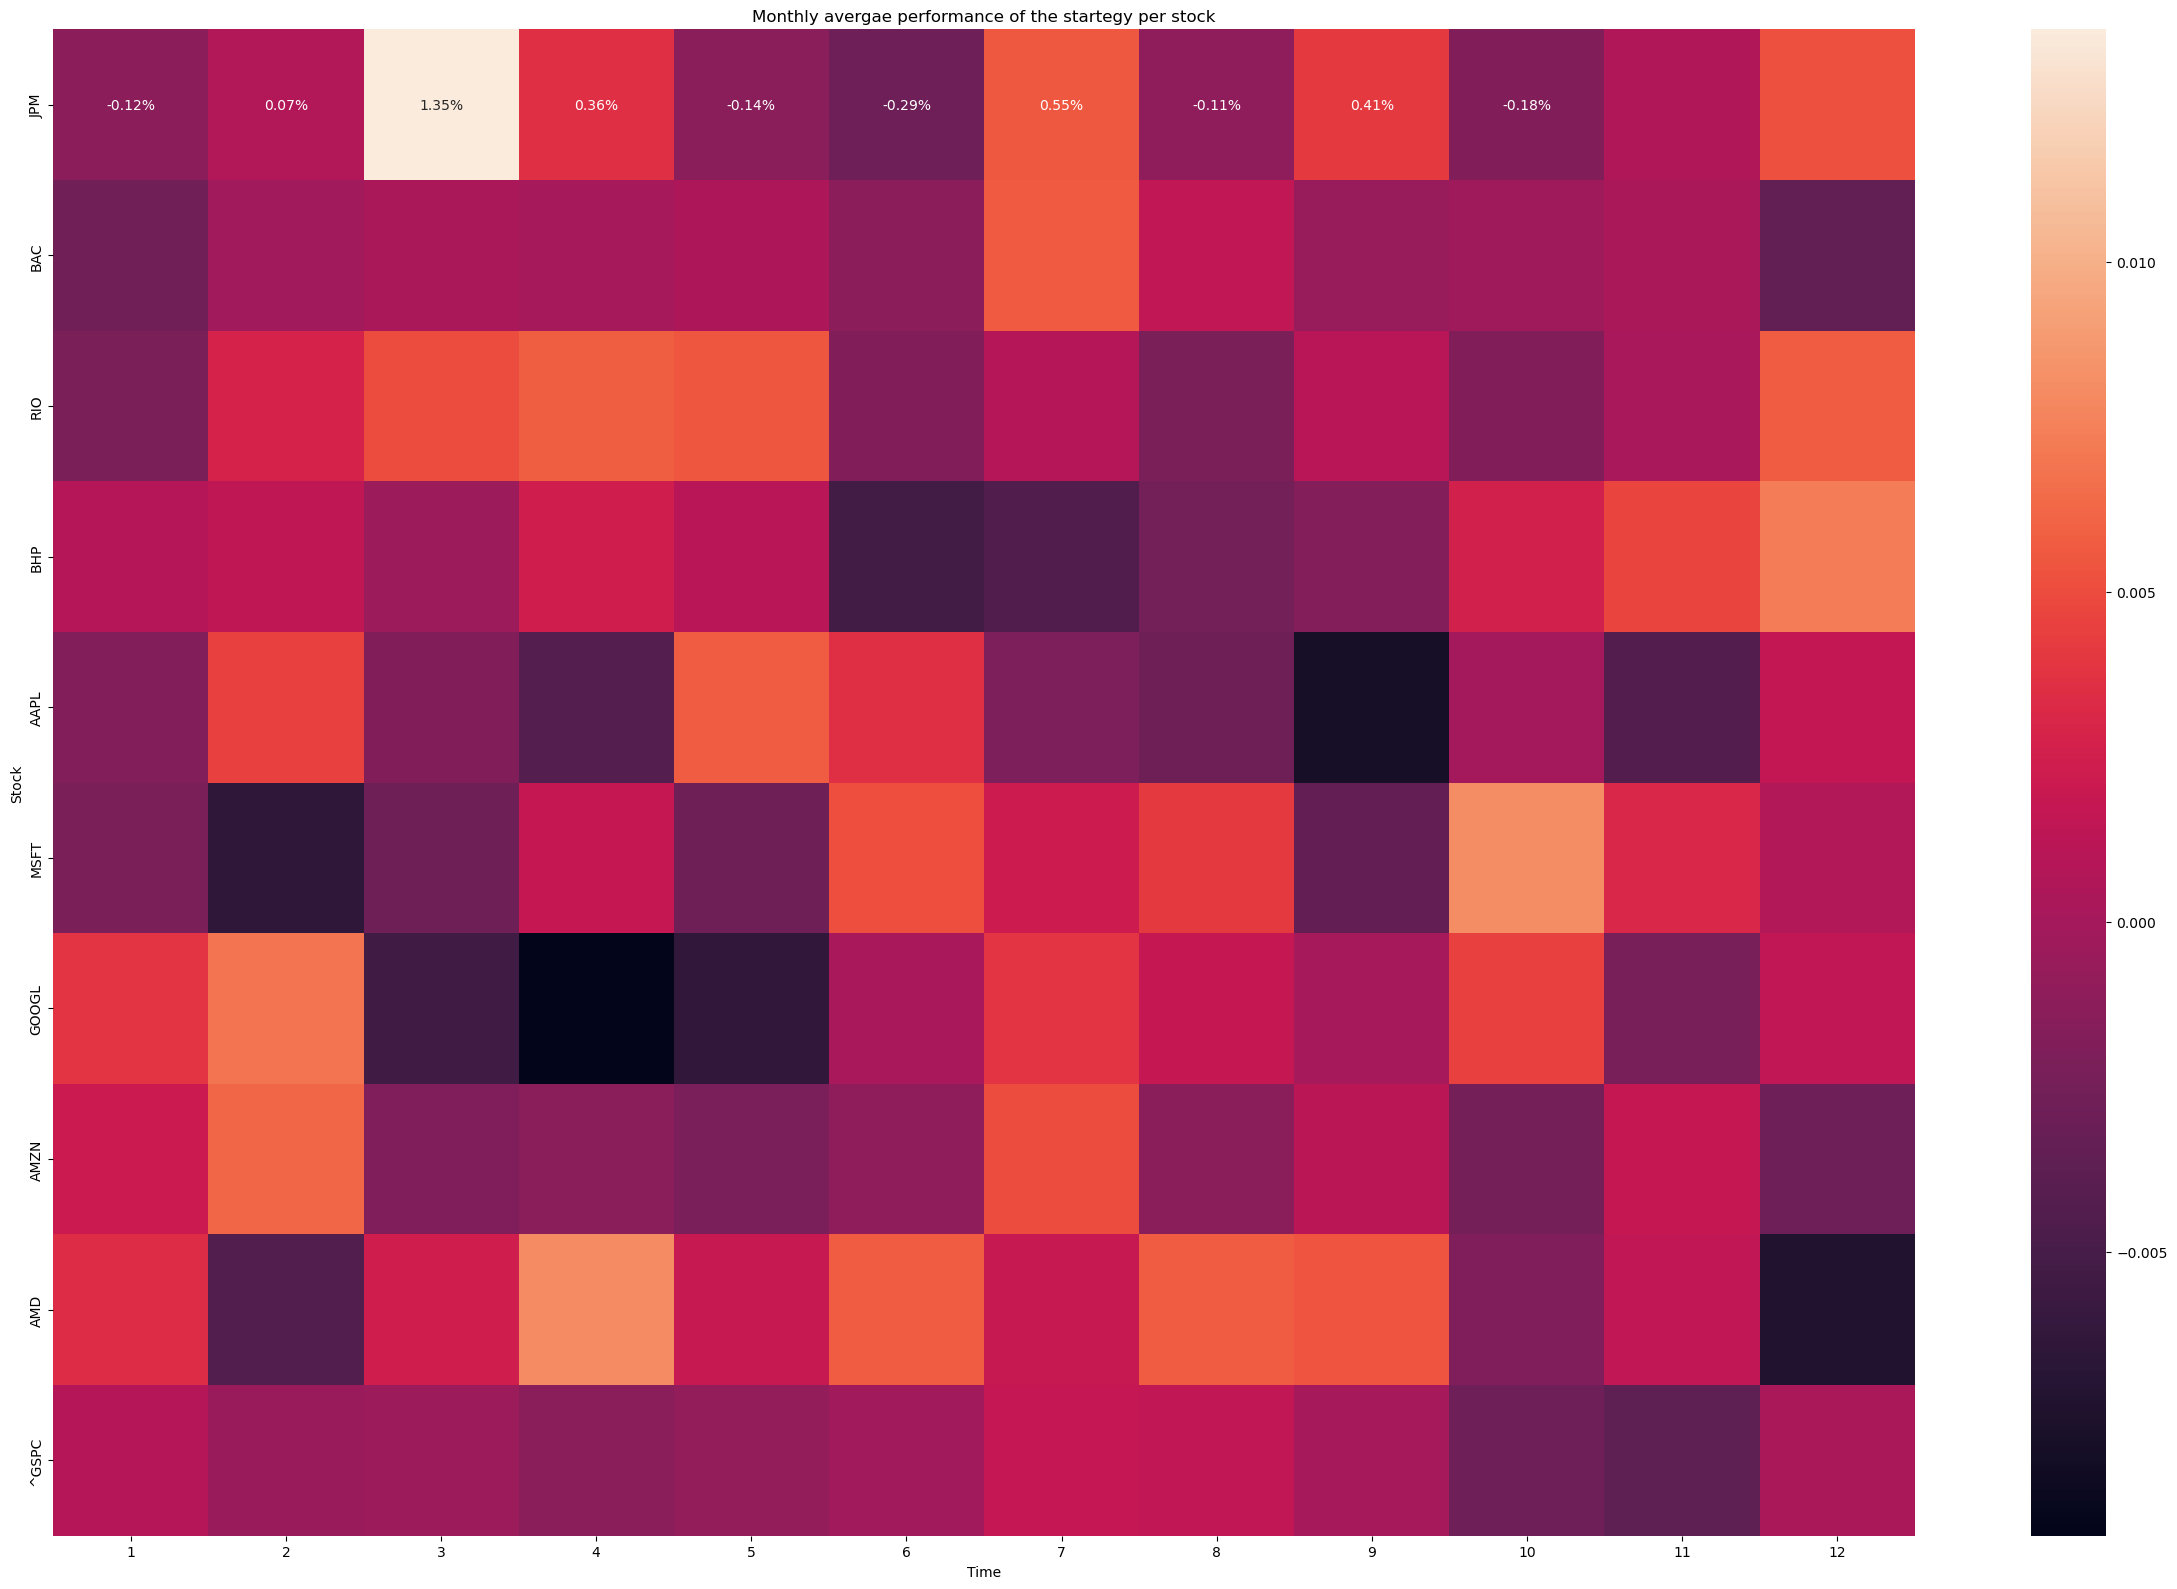

In [121]:
fig,ax=plt.subplots(figsize=(24,16))

sns.heatmap(Monthly_avg_Performance,ax=ax,fmt='.2%',annot=True,yticklabels=tickers, xticklabels=np.arange(1,13))
ax.set_xlabel('Time')
ax.set_ylabel('Stock')
ax.set_title('Monthly avergae performance of the startegy per stock')

plt.tight_layout()
plt.show()

- The performance of the strategy heavily depends on the stock.
- The performance of the strategy heavily depends on the time.

--> there isn't a strategy that can work all the time and on all the stocks at the same time

- The performance of the strategy can be relatively similair for two stocks from the same industry (GOOGL and AMZN)
- For a same stock the performance of the strategy can be very satisfying or catastrophic depending on the time